In [15]:
using Statistics
#using CuArrays
using Random
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


In [174]:
import Flux: Recur

function identities(n::Int64)
    fill(identity, n)
end

# reduce/merge modes in keras: 'sum', 'mul', 'concat', 'ave', None
# see https://github.com/keras-team/keras/blob/master/keras/layers/wrappers.py#L333

function concat(xs)
    # implicit concatenation
    return vcat(xs...)

    # explcit concatenation - preallocated size
    # n = length(xs)
    # m = length(xs[1])
    # concated = Array{eltype(xs[1].data)}(UndefInitializer(), n * m)
    # for i in 1:n
    #     concated[(i-1)*m+1:i*m] = xs[i].data
    # end
    # return param(concated)
end

function mul(xs)
    D = xs[1]
    for i in 2:length(xs)
        D = D .* xs[i]
    end
    D
end

# Parallel

mutable struct Parallel
    layers::Vector
    map::Vector{Function}
    inv::Vector{Function}
    reduce::Function
end

function Parallel(
    layers::Vector;
    map::Dict{Int64,Function} = Dict{Int64,Function}(),
    inv::Dict{Int64,Function} = Dict{Int64,Function}(),
    reduce::Function = concat)

    mappings::Vector{Function} = identities(length(layers))
    for (k,v) in map
        mappings[k] = v
    end

    inverses::Vector{Function} = identities(length(layers))
    for (k,v) in inv
        inverses[k] = v
    end

    return Parallel(layers, mappings, inverses, reduce)
end

function (p::Parallel)(xs)
    # NOTE: The implementation of the mapping is acutally sequential and not parallel.
    #       How to parallelize for cpu() and gpu() ia an open question to me, as `Base.pmap` does not exist anymore and 
    #       `Threads.@threads` does not seem to be a good idea neither.

    # double reverse; analog to `Flux.flip`, but without broadcast; see: recurrent.jl#flip(f, xs)
    # y = map^-1(f(map(x))) or map(x) |> f |> map^-1
    apply(l) = p.inv[l](p.layers[l](p.map[l](xs)))

    # implicit mapping
    Z = map(l -> apply(l), eachindex(p.layers))

    # explicit mapping - preallocated size
    # first = apply(1)
    # Z = Vector{typeof(first)}(UndefInitializer(), length(p.layers))
    # for l in eachindex(p.layers)
    #     if l == 1
    #         Z[l] = first
    #     else
    #         Z[l] = apply(l)
    #     end
    # end

    p.reduce(Z)
end

# NOTE: Instead of generating `Flux.children` and `Flux.mapchildren` with `@treelike` macro, they are defined 
#       explicity, as `@treelike Parallel layers` is considerd not treelike: `error("@treelike T (a, b)")`
Base.getindex(c::Parallel, i::AbstractArray) = Parallel(c.layers[i]...)

function Base.show(io::IO, m::Parallel)
    print(io, "Parallel(\n")
    print(io, "  ", m.layers, ",\n")
    print(io, "     map = ", m.map, ",\n")
    print(io, "     inv = ", m.inv, ",\n")
    print(io, "  reduce = ", m.reduce, "\n")
    print(io, ")")
end



In [320]:
ReLUConvBN(C_in, C_out, kernel_size, stride, pad) = Chain(
    x -> relu.(x),
    Conv(kernel_size, C_in=>C_out),# ,pad=(pad,pad), stride=(stride,stride)),
    BatchNorm(C_out))

FactorizedReduce(C_in, C_out, stride) = Chain(
    x -> relu.(x),
    x -> cat(Conv((1,1), C_in=>C_out÷stride)(x),
            Conv((1,1), C_in=>C_out÷stride)(x[:,:,2:end,2:end]),
            dims=1), #or dims=2?
    BatchNorm(C_out))

SepConv(C_in, C_out, kernel_size, stride, pad) = Chain(
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in),#, stride=(stride,stride), pad=(pad,pad)), 
    Conv(kernel_size, C_in->C_in, pad=0),
    BatchNorm(C_in),
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in),# pad=(pad,pad), stride=(stride,stride)), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

DilConv(C_in, C_out, kernel_size, stride, pad, dilation) = Chain(
    x -> relu.(x),
    DepthwiseConv(kernel_size, C_in=>C_in, pad=(pad,pad), stride=(stride,stride), dilation=dilation), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

Identity(stride) = x -> x[:,:,1:stride:end,1:stride:end]
Zero(stride) = x -> x[:,:,1:stride:end,1:stride:end]*0

struct AdaptiveMeanPool{N}
  target_out::NTuple{N, Int}
end

AdaptiveMeanPool(target_out::NTuple{N, Integer}) where N = 
  AdaptiveMeanPool(target_out)

function (m::AdaptiveMeanPool)(x)
  w = size(x, 1) - m.target_out[1] + 1
  h = size(x, 2) - m.target_out[2] + 1
  return meanpool(x, (w, h); pad = (0, 0), stride = (1, 1))
end


In [338]:
PRIMITIVES = [
    #"none",
    "identity",
    "max_pool_3x3",
    #"avg_pool_3x3",
    #"skip_connect",
    #"sep_conv_3x3",
    #"sep_conv_5x5",
    #"dil_conv_3x3",
    #"dil_conv_5x5"
]



OPS = Dict(
  "none" => (C, stride, w) -> Chain(Zero(stride),x->w.*x),
  "identity" => (C, stride, w) -> Chain(Identity(stride),x->w.*x, x->print(size(x)),
  "avg_pool_3x3" => (C, stride, w) -> Chain(MeanPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  "max_pool_3x3" => (C, stride, w) -> Chain(MaxPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x, x->print(size(x))),
  #"skip_connect" => (C, stride, w) -> Chain(stride == 1 ? Identity() : FactorizedReduce(C, C), x->w.*x),
  "skip_connect" => (C, stride, w) -> Chain(FactorizedReduce(C, C, stride), x->w.*x),
  "sep_conv_3x3" => (C, stride, w)-> SepConv(C, C, 3, stride, 1),
  #"sep_conv_5x5" => (C, stride, w)-> SepConv(C, C, 5, stride, 2),
  #"sep_conv_7x7" => (C, stride, w)-> SepConv(C, C, 7, stride, 3),
  "dil_conv_3x3" => (C, stride, w)-> DilConv(C, C, 3, stride, 2, 2),
  #"dil_conv_5x5" => (C, stride, w)-> DilConv(C, C, 5, stride, 4, 2),
  "conv_7x1_1x7" => (C, stride, w) -> Chain(
                                        x -> relu.(x),
                                        Conv((1,7), C->C, pad=(0,3), stride=(1,stride)), 
                                        Conv((7,1), C->C, pad=(3,0), stride=(stride,1)),
                                        BatchNorm(C_out),
                                        x->w.*x)
    )
            


LoadError: syntax: incomplete: premature end of input

In [339]:
struct DARTSConnection
    layers
    weights
end

DARTSConnection(C, stride, ws) = DARTSConnection([OPS[prim](C,stride,1) for prim in PRIMITIVES], ws)

function (skip::DARTSConnection)(input)
    print(size(layers(input)))
    wsum(layers(input), weights)
end

Flux.@functor DARTSConnection

dc = DARTSConnection(16, 1, [2,3,1])
println(dc)
print(params(dc))

DARTSConnection(Chain[Chain(#1718, #1773), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1777, #1778)], [2, 3, 1])
Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [2, 3, 1]])

In [340]:
function DARTSCell(C_pp, C_p, C, red, red_p, weights, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    model = Chain(
        p0, 
        #p1, 
        DARTSConnection(C, 1, weights[1,:]),
        DARTSConnection(C, 1, weights[2,:]),
        DARTSConnection(C, 1, weights[3,:]),
        DARTSConnection(C, 1, weights[4,:]),
    )
end
test_cell_ = DARTSCell(3, 3, 16, true, false, [1,2,3,4,5,6])
print(test_cell_)
print(params(test_cell_))

Chain(Chain(#1700, Conv((1, 1), 3=>16), BatchNorm(16)), DARTSConnection(Chain[Chain(#1718, #1773), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1777, #1778)], [1]), DARTSConnection(Chain[Chain(#1718, #1773), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1777, #1778)], [2]), DARTSConnection(Chain[Chain(#1718, #1773), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1777, #1778)], [3]), DARTSConnection(Chain[Chain(#1718, #1773), Chain(MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), #1777, #1778)], [4]))Params([Float32[-0.4852911]

Float32[-0.40902773]

Float32[-0.47371808]

Float32[-0.44694734]

Float32[-0.12592535]

Float32[-0.044465173]

Float32[-0.3786678]

Float32[0.25360623]

Float32[0.32692686]

Float32[0.3682308]

Float32[-0.33060595]

Float32[-0.06509483]

Float32[0.51124644]

Float32[0.15861452]

Float32[0.10126465]

Float32[0.019316519]

Float32[-0.41929927]

Float32[0.5

In [341]:
struct MixedOp
    ops
end


function MixedOp(C, stride, w)
    ops = Any[]
    for k in 1:length(PRIMITIVES)
        op = OPS[PRIMITIVES[k]](C, stride, w[k])
        append!(ops, op)
    end
    MixedOp(ops)
end
(m::MixedOp)(x) = sum([op(x) for op in m.ops])
Flux.@functor MixedOp

mod = MixedOp(16,1,[2, 3])
println(mod)
print(params(mod))


MixedOp(Any[var"#1718#1719"{Int64}(1), var"#1773#1791"{Int64}(2), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#1777#1795"{Int64}(3), var"#1778#1796"()])
Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

In [342]:
struct MixOp
    #weights #::
    ops
end

function MixOp(C, stride, w)
    Parallel([OPS["identity"](C, stride, w[1]),OPS["none"](C, stride, w[2])], reduce=sum)
end
(m::MixOp)(x) = sum([op(x) for op in m.ops])
Flux.@functor MixOp

mod = MixOp(16,1,[2,1])
println(mod)
print(params(mod))


Parallel(
  Chain[Chain(#1718, #1773), Chain(#1720, #1771)],
     map = Function[identity, identity],
     inv = Function[identity, identity],
  reduce = sum
)
Params([])

In [343]:
function Cell(C_pp, C_p, C, red, red_p, weights, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    #mixops = MixedOp[]
    #model = x -> p1(p0(x))
    for i = 1:steps
       for j = 1:2+i
            #println(i,j)
            #red && j < 3 ? stride = 2 : stride = 1
            #println(stride)
            #print(mixop)
            #mixop = x -> weights[j,:]'*MixedOp(C, stride)(x)
            #model = Chain(model, x -> weights[j,:]'*mixop(x)) #add skip connections later
            #model = x -> weights[0,:]'*MixedOp(C, stride)(model(x))
            #append!(mixops, mixop)
        end
    end
    #model = Chain(p0, p1, mixops...)
    #states = [p0, p1]
    #offset = 0
    #for i = 1:steps
        #s = sum(weights[offset+j]'*mixops_[offset+j](states[j], weights[offset+j]) for j=1:length(states))
        #offset += length(states)
        #append!(states, s)
    #end
    #return cat(states[end-multiplier:end],dims=1)
    model = Chain(
        p0, 
        #p1, 
        MixedOp(C, 2, weights[1,:]),
        MixedOp(C, 2, weights[2,:]),
        MixedOp(C, 1, weights[3,:]),
        MixedOp(C, 2, weights[4,:]),
        #AdaptiveMeanPool((1,1)),

        #x -> reshape(x, :, size(x,4)),
        #Dense(C, 10),
        #softmax
    )
end

test_cell = Cell(3, 3, 16, false, false, rand(4,3))
print(test_cell)
print(params(test_cell))

Chain(Chain(#1700, Conv((1, 1), 3=>16), BatchNorm(16)), MixedOp(Any[var"#1718#1719"{Int64}(2), var"#1773#1791"{Float64}(0.3294721552790214), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (2, 2)), BatchNorm(16), var"#1777#1795"{Float64}(0.8949848946715382), var"#1778#1796"()]), MixedOp(Any[var"#1718#1719"{Int64}(2), var"#1773#1791"{Float64}(0.9867055899321702), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (2, 2)), BatchNorm(16), var"#1777#1795"{Float64}(0.7845434752519613), var"#1778#1796"()]), MixedOp(Any[var"#1718#1719"{Int64}(1), var"#1773#1791"{Float64}(0.6226394216484252), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#1777#1795"{Float64}(0.8076548271673902), var"#1778#1796"()]), MixedOp(Any[var"#1718#1719"{Int64}(2), var"#1773#1791"{Float64}(0.41395463726181214), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (2, 2)), BatchNorm(16), var"#1777#1795"{Float64}(0.618596068099446), var"#1778#1796"()]))Params([Float32[0.48283795]

Float32[-0.24319252]

Float32[0.

In [345]:
epochs = 10

m = test_cell

for epoch = 1:epochs
    for d in train
        gs = gradient() do
            #print(size(m(d[1])))
            l = loss(d...)
        end
        update!(opt, params(m), gs)
    end
    @show accuracy(valX, valY)
end

(32, 32, 16, 1)

DimensionMismatch: DimensionMismatch("dimensions must match")

In [329]:
function Network(α_normal, α_reduce, num_classes = 10, layers = 8, C = 16, steps = 4, mult = 4 , stem_mult = 3)
    C_c = C*stem_mult
    stem = Chain(
        Conv((3,3), 3=>C_c, pad=(1,1)),
        BatchNorm(C_c)) 
    C_pp = C_c
    C_p = C_c
    C_c = C
    red_p = false
    cells = []
    for i = 1:layers
        if i == layers//3 || i == 2*layers//3
            C_c = C_c*2
            red = true
            weights = α_reduce
        else
            red = false
            weights = α_normal
        end
        cell = Cell(C_pp, C_p, C, red, red_p, weights, steps, mult)
        red_p = red
        #model = cell(model)
        C_pp = C_p
        C_p = 4*C_c #4 is length of DARTS_V1 concat
        if i == 2*layers//3
            C_aux = C_p
        end
        push!(cells, cell)
    end

    s0 = stem
    s1 = stem
    for i = 1:layers
        st = s1
        s1 = Identity()
        s0 = s1
    end
    Chain(s0, cells...)
end
α_normal = 2e-3*(rand(k,num_ops) .- 0.5)
α_reduce = 2e-3*(rand(k,num_ops) .- 0.5)
m = Network(α_normal, α_reduce)
print(test_network)
print(params(test_network))

Chain(Chain(#77), Chain(#77), Chain(Chain(relu, Conv((1, 1), 48=>16), BatchNorm(16)), MixedOp(Any[Chain(#79), var"#207#219"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877]), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#211#223"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877]), MeanPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#209#221"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877]), Chain(relu, Chain(#63, #66), BatchNorm(16)), var"#213#225"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877])]), MixedOp(Any[Chain(#79), var"#207#219"{Array{Float64,1}}([-0.0004286051623680347, -0.0009242993570069551, -0.0009196944361665333, 0.0006286145122550208]), MaxPool((3, 3), pad = (1, 1, 1, 1), stride

00451594552287907, -0.0009858932338526402, -0.0009689286891511877]), MeanPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#209#221"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877]), Chain(relu, Chain(#63, #66), BatchNorm(16)), var"#213#225"{Array{Float64,1}}([0.000977870396222051, 0.000451594552287907, -0.0009858932338526402, -0.0009689286891511877])]), MixedOp(Any[Chain(#79), var"#207#219"{Array{Float64,1}}([-0.0004286051623680347, -0.0009242993570069551, -0.0009196944361665333, 0.0006286145122550208]), MaxPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#211#223"{Array{Float64,1}}([-0.0004286051623680347, -0.0009242993570069551, -0.0009196944361665333, 0.0006286145122550208]), MeanPool((3, 3), pad = (1, 1, 1, 1), stride = (1, 1)), BatchNorm(16), var"#209#221"{Array{Float64,1}}([-0.0004286051623680347, -0.0009242993570069551, -0.0009196944361665333, 0.0006286145122550208]), Chain(r

Float32[0.08058874]

Float32[-0.116932616]

Float32[0.21936727]

Float32[-0.019883653]

Float32[-0.24144006]

Float32[0.17845269]

Float32[-0.2833019]

Float32[0.09358378]

Float32[-0.30345258]

Float32[0.18091609]

Float32[0.15474942]

Float32[-0.1879888]

Float32[-0.0005396926]

Float32[-0.21735267]

Float32[-0.124070965]

Float32[-0.21695335]

Float32[0.25549206]

Float32[-0.20978908]

Float32[0.029123105]

Float32[0.12329891]

Float32[-0.0047334973]

Float32[0.16227885]

Float32[0.18515654]

Float32[-0.002418214]

Float32[0.026789717]

Float32[0.07152427]

Float32[0.20913237]

Float32[0.021794368]

Float32[0.088054575]

Float32[0.274006]

Float32[0.025578203]

Float32[0.084746115]

Float32[0.20929837]

Float32[-0.13864048]

Float32[0.2147383]

Float32[0.24845913]

Float32[-0.16604728]

Float32[0.2959119]

Float32[0.22350742]

Float32[-0.14459455]

Float32[-0.049574703]

Float32[-0.2597704]

Float32[-0.25902382]

Float32[0.29721937]

Float32[-0.08524668]

Float32[0.12188417]

Float3

Float32[0.20641157]

Float32[-0.29204553]

Float32[-0.22776918]

Float32[-0.22503334]

Float32[0.1698633]

Float32[0.063959226]

Float32[-0.04852262]

Float32[0.15032741]

Float32[0.10898615]

Float32[-0.0034102176]

Float32[-0.09291641]

Float32[-0.14016575]

Float32[0.1015009]

Float32[-0.11311235]

Float32[0.051224295]

Float32[0.16641818]

Float32[0.29833874]

Float32[-0.09626326]

Float32[0.21600872]

Float32[0.29193932]

Float32[0.27931723]

Float32[-0.079266116]

Float32[-0.08519135]

Float32[0.14278807]

Float32[-0.17929466]

Float32[0.041269436]

Float32[0.21843052]

Float32[0.22283465]

Float32[-0.12050139]

Float32[0.18310624]

Float32[-0.23115407]

Float32[-0.17207003]

Float32[0.28872275]

Float32[-0.22316052]

Float32[0.09698399]

Float32[-0.0038001132]

Float32[-0.30536702]

Float32[-0.19983861]

Float32[-0.11454375]

Float32[0.1812992]

Float32[0.18394633]

Float32[-0.0026048764]

Float32[-0.11313243]

Float32[0.14738959]

Float32[0.02976843]

Float32[0.30110365]

Float

Float32[-0.18692532]

Float32[0.09354375]

Float32[0.24760692]

Float32[0.25838554]

Float32[-0.15630221]

Float32[0.092920266]

Float32[0.2464336]

Float32[0.02878639]

Float32[0.09822544]

Float32[0.25168672]

Float32[-0.14743939]

Float32[-0.14579171]

Float32[0.25711504]

Float32[-0.21760267]

Float32[-0.09775604]

Float32[-0.07811245]

Float32[0.26514336]

Float32[-0.11139699]

Float32[-0.1137802]

Float32[0.11224515]

Float32[-0.12859584]

Float32[0.086310916]

Float32[-0.17726101]

Float32[0.2714545]

Float32[-0.26340374]

Float32[0.062040888]

Float32[0.16018379]

Float32[-0.20793536]

Float32[-0.123044066]

Float32[-0.07992279]

Float32[-0.23171164]

Float32[0.18712929]

Float32[-0.26571584]

Float32[0.1945539]

Float32[-0.11987092]

Float32[-0.1717706]

Float32[0.1062066]

Float32[0.0692288]

Float32[-0.16701403]

Float32[0.030004965]

Float32[-0.14368291]

Float32[-0.09367996]

Float32[0.07582287]

Float32[-0.11040276]

Float32[-0.16505738]

Float32[-0.05162453]

Float32[0.1

Float32[-0.18932538]

Float32[-0.125672]

Float32[-0.21555604]

Float32[-0.25300384]

Float32[-0.10524378]

Float32[0.13248566]

Float32[0.1706565]

Float32[-0.06658082]

Float32[0.12338411]

Float32[0.057118203]

Float32[0.2685311]

Float32[-0.22650611]

Float32[-0.13595124]

Float32[0.018566959]

Float32[-0.15711199]

Float32[-0.26851517]

Float32[0.14501472]

Float32[-0.12892061]

Float32[0.117110506]

Float32[0.2476935]

Float32[-0.0005956084]

Float32[-0.2029432]

Float32[-0.00872388]

Float32[-0.20051612]

Float32[0.106921434]

Float32[-0.1210084]

Float32[-0.20279983]

Float32[-0.22166432]

Float32[-0.23133034]

Float32[0.069933124]

Float32[-0.19333121]

Float32[-0.19858055]

Float32[-0.21102996]

Float32[-0.04175037]

Float32[-0.079696216]

Float32[0.14540139]

Float32[0.11465207]

Float32[0.18596067]

Float32[-0.11242889]

Float32[0.20354979]

Float32[-0.12549172]

Float32[0.15523532]

Float32[0.049146507]

Float32[0.12363308]

Float32[0.09089218]

Float32[0.15571405]

Float3

Float32[-0.24751225]

Float32[-0.05073621]

Float32[0.022849372]

Float32[-0.23808691]

Float32[0.12297962]

Float32[-0.24687916]

Float32[-0.09550883]

Float32[-0.12912317]

Float32[0.16212791]

Float32[-0.086843714]

Float32[-0.1170648]

Float32[0.065563805]

Float32[-0.015283995]

Float32[-0.25907955]

Float32[0.1763424]

Float32[-0.083251126]

Float32[0.09141753]

Float32[0.18364379]

Float32[0.15684547]

Float32[-0.019359035]

Float32[0.0064583225]

Float32[-0.17156166]

Float32[-0.12467974]

Float32[0.1393887]

Float32[-0.028624918]

Float32[-0.04469394]

Float32[0.14940943]

Float32[-0.18153723]

Float32[-0.09644129]

Float32[-0.097208425]

Float32[0.08112217]

Float32[0.2574146]

Float32[0.09732654]

Float32[0.04300009]

Float32[-0.037709285]

Float32[-0.19790724]

Float32[-0.079740554]

Float32[-0.11390165]

Float32[-0.018582499]

Float32[-0.15879996]

Float32[-0.26957965]

Float32[0.13140602]

Float32[-0.18246034]

Float32[-0.068487786]

Float32[-0.071781255]

Float32[0.26775

Float32[-0.06829275]

Float32[0.1898192]

Float32[-0.08327594]

Float32[-0.06582654]

Float32[-0.21912284]

Float32[0.052205577]

Float32[0.11964964]

Float32[0.21736847]

Float32[0.20326027]

Float32[-0.068538845]

Float32[0.2496751]

Float32[0.021388885]

Float32[-0.21845266]

Float32[-0.115105204]

Float32[-0.07559519]

Float32[0.053277113]

Float32[-0.042914752]

Float32[0.07523568]

Float32[-0.21866813]

Float32[0.06096165]

Float32[0.09699452]

Float32[0.083696626]

Float32[-0.095779404]

Float32[0.18258348]

Float32[0.15699282]

Float32[0.12575687]

Float32[0.07378218]

Float32[-0.030753426]

Float32[-0.23285213]

Float32[0.24275437]

Float32[-0.09973254]

Float32[0.20857224]

Float32[-0.16899477]

Float32[0.06752411]

Float32[-0.05941863]

Float32[-0.18203227]

Float32[0.19963406]

Float32[0.12681085]

Float32[-0.14305335]

Float32[-0.23878928]

Float32[-0.12119593]

Float32[-0.18844534]

Float32[0.27367428]

Float32[-0.21295704]

Float32[-0.24592084]

Float32[0.20969398]

Floa

Float32[-0.14193566], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],

Float32[0.029727532]

Float32[0.11280654]

Float32[0.06672486]

Float32[-0.01955113]

Float32[0.2268348]

Float32[-0.26492494]

Float32[-0.21477233]

Float32[0.17199077]

Float32[-0.09454026]

Float32[-0.23266742]

Float32[-0.15344007]

Float32[-0.25429848]

Float32[-0.1186784]

Float32[-0.030013584]

Float32[-0.048359655]

Float32[-0.20316848]

Float32[0.18243638]

Float32[-0.05974536]

Float32[-0.19623664]

Float32[0.112223476]

Float32[-0.2578955]

Float32[-0.1122524]

Float32[0.1999307]

Float32[0.2336828]

Float32[0.06795362]

Float32[0.24865448]

Float32[0.12613016]

Float32[0.20838903]

Float32[0.23951514]

Float32[0.19356835]

Float32[-0.2542378]

Float32[-0.27076983]

Float32[0.10109078]

Float32[-0.13013743]

Float32[0.25122157]

Float32[0.058946755]

Float32[-0.23065095]

Float32[0.17108808]

Float32[0.24430548]

Float32[0.27083597]

Float32[0.04029687]

Float32[-0.22703688]

Float32[-0.08412306]

Float32[0.23396924]

Float32[-0.21219113]

Float32[0.002543513]

Float32[-0.25

Float32[0.16215546], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 

Float32[0.041794118]

Float32[-0.03895476]

Float32[0.021502169]

Float32[0.08181741]

Float32[-0.22970426]

Float32[0.062242188]

Float32[-0.035021342]

Float32[-0.22288108]

Float32[-0.17516588]

Float32[-0.23188251]

Float32[0.13831441]

Float32[-0.26533198]

Float32[0.2495142]

Float32[-0.21157953]

Float32[-0.06289323]

Float32[-0.06730701]

Float32[0.15729624]

Float32[-0.15934698]

Float32[-0.120677106]

Float32[-0.037886556]

Float32[0.118337505]

Float32[0.16451406]

Float32[-0.167985]

Float32[-0.16429278]

Float32[0.034739472]

Float32[-0.22419576]

Float32[-0.13773486]

Float32[-0.26005965]

Float32[-0.037618134]

Float32[0.21297807]

Float32[0.27346915]

Float32[-0.12241026]

Float32[-0.16178721]

Float32[-0.21378209]

Float32[0.071883574]

Float32[-0.11634624]

Float32[-0.09282278]

Float32[0.05049789]

Float32[0.034404773]

Float32[0.24866526]

Float32[0.2392541]

Float32[-0.14510664]

Float32[0.097717255]

Float32[0.16527493]

Float32[-0.10105611]

Float32[0.14295469]



Float32[-0.13709897]

Float32[-0.16446881]

Float32[0.10879432]

Float32[0.030946173]

Float32[-0.05376035]

Float32[-0.17074478]

Float32[0.019540813]

Float32[-0.22380674]

Float32[0.09422346]

Float32[-0.041409343]

Float32[-0.060744483]

Float32[0.24251272]

Float32[-0.06797686]

Float32[-0.008050507]

Float32[-0.008817446]

Float32[-0.06166016]

Float32[0.09303871]

Float32[0.21600944]

Float32[-0.26142403]

Float32[0.16162279]

Float32[-0.1757646]

Float32[0.26841477]

Float32[0.036782768]

Float32[0.22284262]

Float32[0.09984942]

Float32[-0.050810188]

Float32[0.18124928]

Float32[-0.11769162]

Float32[0.17665829]

Float32[0.21778478]

Float32[0.19264661]

Float32[-0.09849837]

Float32[0.062378913]

Float32[-0.09413851]

Float32[0.11452318]

Float32[-0.07630003]

Float32[0.0341404]

Float32[0.27243885]

Float32[-0.0296672]

Float32[0.15493725]

Float32[-0.20486858]

Float32[0.19949839]

Float32[0.062230173]

Float32[0.16155763]

Float32[-0.124102406]

Float32[0.13498972]

Float

Float32[0.007970392]

Float32[-0.26284978]

Float32[-0.24481803]

Float32[0.051276516]

Float32[-0.07604885]

Float32[0.013609671]

Float32[-0.26995516]

Float32[-0.20802175]

Float32[-0.09536558]

Float32[0.15308252]

Float32[0.17862087]

Float32[0.103651404]

Float32[0.04449323]

Float32[-0.085100636]

Float32[0.18958557]

Float32[-0.26992533]

Float32[0.025185054]

Float32[-0.13781172]

Float32[-0.24757114]

Float32[-0.08490645]

Float32[0.05591935]

Float32[-0.13700058]

Float32[0.14648415]

Float32[0.21185279]

Float32[0.020383622]

Float32[-0.08310056]

Float32[0.19559683]

Float32[-0.0022180895]

Float32[-0.12300293]

Float32[0.1665618]

Float32[-0.1572348]

Float32[0.16572279]

Float32[-0.04677994]

Float32[-0.046494674]

Float32[0.23127908]

Float32[0.009067913]

Float32[0.09804425]

Float32[-0.12639076]

Float32[0.13104959]

Float32[-0.12908156]

Float32[0.26247925]

Float32[-0.12638076]

Float32[0.12290075]

Float32[0.20025449]

Float32[-0.029021643]

Float32[-0.19207704]

F

Float32[-0.27249947]

Float32[0.2007135]

Float32[0.26539826]

Float32[-0.22704151]

Float32[0.16554002]

Float32[-0.22038287]

Float32[-0.0657288]

Float32[-0.0047944454]

Float32[0.0022354575]

Float32[-0.1330099]

Float32[-0.23401247]

Float32[-0.1112301]

Float32[0.051994745]

Float32[0.17367594]

Float32[-0.15071276]

Float32[0.15331464]

Float32[0.09275573]

Float32[0.14108318]

Float32[-0.038381614]

Float32[0.21363465]

Float32[0.26949236]

Float32[-0.17697887]

Float32[0.14334947]

Float32[-0.20947571]

Float32[0.11750612]

Float32[-0.13869344]

Float32[0.26413187]

Float32[-0.19122529]

Float32[0.1750142]

Float32[0.1607788]

Float32[-0.018405683]

Float32[-0.2596683]

Float32[-0.06407537]

Float32[0.10333551]

Float32[0.17018814]

Float32[0.013101099]

Float32[-0.1355517]

Float32[-0.13643494]

Float32[-0.2014963]

Float32[0.23996261]

Float32[-0.18708026]

Float32[0.16557972]

Float32[0.23043849]

Float32[0.13949145]

Float32[0.1664273]

Float32[0.16703819]

Float32[0.14035

Float32[-0.07151545], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],

Float32[0.094558544]

Float32[-0.020998623]

Float32[0.10724915]

Float32[-0.26419798]

Float32[-0.1682358]

Float32[-0.1372374]

Float32[-0.23604387]

Float32[0.029660542]

Float32[0.12638403]

Float32[0.009416842]

Float32[0.10328484]

Float32[-0.24795781]

Float32[-0.09226197]

Float32[-0.21085504]

Float32[0.17411596]

Float32[-0.24024284]

Float32[-0.07676538]

Float32[0.22644232]

Float32[0.03615027]

Float32[-0.12741338]

Float32[0.11829219]

Float32[-0.088465676]

Float32[0.06129197]

Float32[0.2574987]

Float32[0.2324069]

Float32[0.23010352]

Float32[-0.24424691]

Float32[0.06300972]

Float32[-0.089777745]

Float32[0.11386992]

Float32[-0.17545956]

Float32[-0.03238988]

Float32[-0.063465856]

Float32[0.11857491]

Float32[-0.1877644]

Float32[0.20989895]

Float32[-0.10197825]

Float32[0.050335895]

Float32[0.09006079]

Float32[-0.18186401]

Float32[0.108676136]

Float32[-0.05239813]

Float32[-0.18507816]

Float32[0.2270423]

Float32[-0.26013684]

Float32[0.17146288]

Float32[

Float32[-0.078167364]

Float32[-0.012409509]

Float32[-0.20462707]

Float32[0.033224266]

Float32[-0.253034]

Float32[-0.102706864]

Float32[0.25053683]

Float32[0.005369878]

Float32[-0.06946647]

Float32[-0.22116692]

Float32[-0.09721162]

Float32[-0.13191406]

Float32[0.21623105]

Float32[-0.22151344]

Float32[-0.16712287]

Float32[-0.22393459]

Float32[0.17155324]

Float32[0.0902314]

Float32[0.012854747]

Float32[-0.18778321]

Float32[0.07074851]

Float32[-0.03941593]

Float32[0.07465242]

Float32[-0.060112376]

Float32[0.18363707]

Float32[-0.21779947]

Float32[-0.2337441]

Float32[0.011798884]

Float32[0.23878615]

Float32[-0.13208756]

Float32[0.11828083]

Float32[0.077119865]

Float32[-0.098782256]

Float32[0.15401119]

Float32[-0.040169157]

Float32[-0.071564026]

Float32[0.16097777]

Float32[-0.25556687]

Float32[-0.011679723]

Float32[0.02450476]

Float32[-0.020538108]

Float32[0.031678896]

Float32[-0.07281936]

Float32[-0.123106286]

Float32[-0.07760728]

Float32[-0.08138

Float32[-0.13328634]

Float32[0.13175142]

Float32[0.10995655]

Float32[0.110067084]

Float32[0.25383657]

Float32[0.08844158]

Float32[-0.01660913]

Float32[-0.14749743]

Float32[-0.26040435]

Float32[-0.22471015]

Float32[0.20137812]

Float32[-0.2459484]

Float32[0.051673695]

Float32[0.00730949]

Float32[-0.04179301]

Float32[-0.024455072]

Float32[0.23617838]

Float32[0.20618138]

Float32[-0.25410298]

Float32[-0.18242294]

Float32[0.106677175]

Float32[-0.26309738]

Float32[-0.23524971]

Float32[0.16106872]

Float32[-0.23894781]

Float32[0.21416327]

Float32[0.23384139]

Float32[0.1948105]

Float32[0.16018836]

Float32[0.0503295]

Float32[0.23860365]

Float32[-0.1681756]

Float32[-0.0395157]

Float32[0.029352356]

Float32[0.19483478]

Float32[-0.06756767]

Float32[0.12484349]

Float32[-0.031311557]

Float32[-0.010410676]

Float32[-0.23681284]

Float32[0.16831625]

Float32[-0.2729178]

Float32[-0.13489695]

Float32[-0.124329954]

Float32[0.15068142]

Float32[0.06063799]

Float32[0.

Float32[-0.06266163]

Float32[-0.02731761]

Float32[0.23231]

Float32[0.2578852]

Float32[0.262294]

Float32[0.21621943]

Float32[0.2550171]

Float32[-0.15045825]

Float32[-0.05525453]

Float32[0.10646157]

Float32[-0.2208498]

Float32[-0.16999716]

Float32[-0.06716846]

Float32[0.033604536]

Float32[0.15494476]

Float32[-0.21962573]

Float32[0.079283364]

Float32[-0.07068289]

Float32[-0.25528544]

Float32[0.14333294]

Float32[0.1592337]

Float32[0.047135726]

Float32[0.21714732]

Float32[0.25175658]

Float32[-0.16313095]

Float32[0.08976142]

Float32[0.11009882]

Float32[-0.2108154]

Float32[-0.0061505935]

Float32[-0.12911402]

Float32[0.23623897]

Float32[0.249708]

Float32[0.031136373]

Float32[0.2388534]

Float32[0.1384241]

Float32[-0.026379537]

Float32[0.18794364]

Float32[0.1691652]

Float32[-0.066821754]

Float32[-0.14427318]

Float32[-0.21680851]

Float32[0.11392124]

Float32[-0.08662805]

Float32[-0.24155681]

Float32[0.003288056]

Float32[-0.06497479]

Float32[0.071748674

In [330]:
steps = 4
k = floor(Int, steps^2/2+3*steps/2)
num_ops = length(PRIMITIVES)
α_normal = 2e-3*(rand(k,num_ops) .- 0.5)
α_reduce = 2e-3*(rand(k,num_ops) .- 0.5)

14×2 Array{Float64,2}:
  0.000594422  -0.000268114
 -0.000198926   0.00021893 
 -0.000948327   0.000680263
 -0.000283168   0.000140122
 -0.000673746  -0.000511404
 -0.000719279   0.000652272
  0.000268567   0.000362955
 -0.000768084   0.000217294
 -0.000231386  -0.000118268
  0.000658214   0.000369644
 -0.000929073  -0.000775595
 -0.000664896  -0.000428214
 -0.000521388  -0.000853541
  0.000469026  -0.000540121

In [92]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

w_opt = Momentum(params, η = 0.01; ρ = 0.9)
α_opt = ADAMW(η = 3*10^-4, β = (0.5, 0.999), decay = 10^-3)


MethodError: MethodError: no method matching Momentum(::typeof(params); η=0.01, ρ=0.9)
Closest candidates are:
  Momentum(::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:59 got unsupported keyword arguments "η", "ρ"
  ...

In [93]:
Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) #|> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) #|> gpu
valY = labels[:, valset] #|> gpu

10×1000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  1  0  1  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  1  0  0

,,,,,,,,,

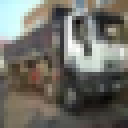
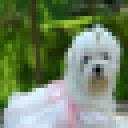
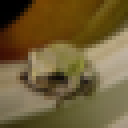
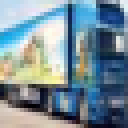
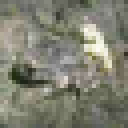
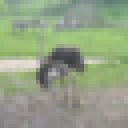
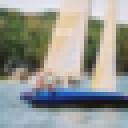
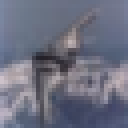
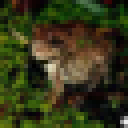
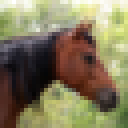

In [25]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])
ids = rand(1:10000, 10)
image.(valset[ids])

In [26]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)


UndefVarError: UndefVarError: m not defined

In [27]:
accuracy(test[1]...)


UndefVarError: UndefVarError: m not defined

In [28]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

UndefVarError: UndefVarError: m not defined

In [153]:
using Statistics
using CuArrays
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


Metalhead.download(Metalhead.CIFAR10)
X = trainimgs(Metalhead.CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img 
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

batch_size = 1


train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, batch_size)])
train_data = train |>
  x -> map(y->gpu.(y),x)
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4)
valY = labels[:, valset]


identity_layer(n) = Chain(
                              Conv((3,3), n=>n, pad = (1,1), stride = (1,1)),
                              BatchNorm(n,relu),
                              Conv((3,3), n=>n, pad = (1,1), stride = (1,1)),
                              BatchNorm(n,relu)
                              )

convolution_layer(n) = Chain(
                             Conv((3,3), n=> 2*n, pad = (1,1), stride = (2,2)),
                             BatchNorm(2*n,relu),
                             Conv((3,3), 2*n=>2*n, pad = (1,1), stride = (1,1)),
                             BatchNorm(2*n,relu)
                             )

simple_convolution(n) = Chain(
                              Conv((1,1), n=>n, pad = (1,1), stride = (2,2)),
                              BatchNorm(n,relu)
                              )


m_filter(n) = Chain(
  Conv((3,3), n=>2*n, pad = (1,1), stride = (2,2)),
  BatchNorm(2*n,relu),
) |> gpu

struct Combinator
    conv::Chain
end |> gpu
Combinator(n) = Combinator(m_filter(n))


function (op::Combinator)(x, y)
  z = op.conv(y)
  return x + z
end

n = 7

m = Chain(

  ConvTranspose((n, n), 3 => 3, stride = n),
  Conv((7,7), 3=>64, pad = (3,3), stride = (2,2)),
  BatchNorm(64,relu),
  MaxPool((3,3), pad = (1,1), stride = (2,2)),
  SkipConnection(identity_layer(64), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(identity_layer(64), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(64), Combinator(64)),
  SkipConnection(identity_layer(128), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(128), Combinator(128)),
  SkipConnection(identity_layer(256), (variable_1, variable_2) -> variable_1 + variable_2),
  SkipConnection(convolution_layer(256), Combinator(256)),
  SkipConnection(identity_layer(512), (variable_1, variable_2) -> variable_1 + variable_2),
  MeanPool((7,7)),
  x -> reshape(x, :, size(x,4)),
  Dense(512, 10),
  softmax,
) #|> gpu

print(m)
print(params(m))

using Flux: crossentropy, Momentum, @epochs

loss(x, y) = sum(crossentropy(m(x), y))
opt = Momentum(0.01)


@epochs 1  train!(loss, params(m), train_data, opt)

Chain(ConvTranspose((7, 7), 3=>3), Conv((7, 7), 3=>64), BatchNorm(64, λ = relu), MaxPool((3, 3), pad = (1, 1), stride = (2, 2)), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), #880), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu)), #881), SkipConnection(Chain(Conv((3, 3), 64=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), Combinator(Chain(Conv((3, 3), 64=>128), BatchNorm(128, λ = relu)))), SkipConnection(Chain(Conv((3, 3), 128=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu)), #882), SkipConnection(Chain(Conv((3, 3), 128=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = relu)), Combinator(Chain(Conv((3, 3), 128=>256), BatchNorm(256, λ = relu)))), SkipConnection(Chain(Conv((3, 3), 256=>256), BatchNorm(256, λ = relu), Conv((3, 3), 256=>256), BatchNorm(256, λ = 

Float32[-0.015517536 -0.007250733 -0.01871127 0.027597653 -0.028800897 -0.010620727 0.0425444; 0.006943165 -0.014454387 -0.016383225 -0.037386876 -0.020258194 -0.007441608 -0.02003922; 0.042226892 0.022554247 0.008867751 0.0019605865 -0.017979043 -0.033270527 -0.009592152; 0.0002209324 -0.011039873 0.03604954 0.01691197 -0.021615406 -0.026906643 0.04170254; -0.028294453 -0.041343063 0.03129434 -0.011487211 -0.017977554 0.0067264824 0.02300022; -0.019525325 -0.02732533 -0.041614886 -0.027640574 0.01399914 0.028297154 0.035983533; 0.02763402 0.024874719 -0.038001504 -0.040698886 -0.011950612 0.012112194 0.0003425288]

Float32[0.00902651 -0.01268171 0.0018359426 0.016446836 -0.024764193 0.023786243 -0.0011779766; -0.023562009 -0.008272011 0.027174523 -0.034842893 -0.026102833 -0.015565022 -0.017067742; -0.03749912 -0.035448357 0.007688827 0.0397773 0.018567108 -0.03775653 -0.0041557737; 0.022885645 0.02435741 -0.006033159 -0.004649671 0.024650566 -0.0006918662 -0.037138436; 0.022618275 -0

Float32[-0.012156766 0.032191887 -0.0011028477 -0.03977518 -0.022878632 0.02847011 -0.021814242; 0.02467299 0.02843411 0.035182495 0.025262952 0.031009855 8.962256e-5 -0.018176123; -0.020262923 0.040901963 0.016483499 0.028770728 -0.034770362 -0.00944538 9.085585e-5; -0.040331967 0.034364283 0.040047687 -0.020215081 0.0426669 -0.039003517 -0.03237191; -0.035314154 -0.007834243 0.019444976 -0.031775452 -0.02757151 0.032150354 -0.02154253; 0.021167478 0.014946991 -0.026112914 0.041855182 0.0031781609 -0.03537494 -0.01861442; 0.01472248 0.0036779088 0.01254302 0.035252877 -0.032369208 0.0081772 -0.03408033]

Float32[-0.026755111 0.0066610263 0.0047308747 -0.021384098 0.022884423 -0.005168428 -0.023191104; -0.04171724 -0.0271267 -0.031136455 -0.012428212 -0.03893642 -0.040593445 0.024710499; -0.023282805 -0.041526973 -0.032276098 -0.004175476 -0.037683398 0.000676873 -0.0028436943; 0.0017380742 -0.031414017 0.015578415 -0.008268535 8.252859e-5 -0.022699397 -0.0030951125; -0.019369522 -0.03

Float32[-0.0017991578 0.019949608 0.010567369 0.03823224 0.03952255 0.03124584 0.033450548; 0.030372936 -0.0049602157 -0.018296711 -1.5370275e-5 0.005313182 -0.007972759 -0.018076707; 0.041308735 0.01065632 0.006229283 -0.028908143 0.029988414 0.012339038 0.033943325; -0.00053965155 -0.017320322 0.0073043252 0.035039037 0.034591373 -0.017643342 -0.009368203; -0.002162734 -0.02303258 0.0340766 0.03104455 0.02597449 0.025198402 0.016609956; -0.01647936 0.010802898 -0.0325806 -0.036022164 -0.015611102 -0.015634077 -0.021799177; 0.041157935 -0.032874417 -0.018070143 0.020902269 0.011481381 0.016196916 0.025989523]

Float32[0.0071715275 -0.0134991985 -0.012953615 -0.028236905 0.01031431 0.007974971 -0.026448583; -0.0053754477 0.041484576 -0.03616804 0.036068864 -0.0023687447 -0.016280383 -0.027428398; -0.029485343 0.04103495 0.017568957 0.021162696 0.014518936 -0.007636366 0.022729058; -0.03815279 0.03492845 -0.012673953 0.036980197 -0.025812807 0.021808706 -0.025358852; -0.008405868 -0.032

Float32[0.01846128 -0.042416606 -0.0067166365 -0.0025794948 0.03120342 -0.038636975 0.011585895; -0.029064994 -0.008533438 0.0066009313 0.024347901 -0.0027082565 -0.0041675563 -0.0030884058; -0.02755192 -0.034399368 -0.02579818 -0.032357473 0.0052469815 -0.017118448 0.0053317524; 0.03302642 0.0023877027 -0.010368912 -0.02775733 0.0016087826 -0.019413482 -0.028262815; -0.039456606 0.01832154 -0.021346906 0.025760213 -0.008136654 -0.009731381 -0.029540291; -0.022552768 0.013711202 0.010775041 0.01125736 -0.02278157 -0.020686574 0.031192381; -0.0336519 0.041609462 -0.041883335 0.03899727 -0.016470471 -0.0039263302 0.008268708]

Float32[0.022757985 0.01897237 -0.027136454 0.010832904 0.032095008 0.007972504 -0.013118508; 0.0331033 0.0140284635 0.00596704 0.021702614 0.019848213 -0.009566274 0.017789278; 0.0065424265 -0.02410121 -0.019100461 -0.012829857 0.031611957 -0.038993783 0.019290755; -0.015869105 -0.035261855 0.029046303 -0.018109964 -0.03377783 0.007171813 0.0127585605; -0.03824805

Float32[0.0165927 0.014492079 -0.036297668 0.011805563 0.017673746 -0.0008571782 -0.0068254517; -0.008694469 -0.025569623 0.035540976 0.01715027 -0.009279385 -0.03715673 -0.016787855; -0.033440325 -0.028098563 -0.041522417 0.025441911 0.0055703893 0.008405929 -0.04269214; -0.025943117 -0.027640788 -0.00036786732 -0.02190994 -0.033157095 0.012664423 -0.01188168; 0.03863024 -0.023246102 -0.0077840146 -0.041033395 -0.023606682 -0.034666482 -0.032500107; -0.020884013 -0.010431177 -0.005840388 0.03951613 -0.04204397 -0.0284352 0.041589282; 0.020230737 -0.0017524253 0.039903138 0.03848261 0.041788097 0.0040968712 -0.0328465]

Float32[-0.01850059 -0.013592082 0.017594397 -0.004070554 0.021518333 0.0121464105 -0.030632712; -0.0026182365 -0.03630893 -0.015861817 -0.02282506 0.020971669 0.033593364 0.0037978643; 0.034378972 -0.025250793 -0.03406076 0.030445222 -0.040013116 -0.004451009 -0.023597682; -0.037862174 0.037924267 -0.027080802 0.021878608 0.034851067 0.028749548 0.04254593; -0.02515019

Float32[0.022857025 0.007426625 0.030281296 -0.021469347 -0.031973187 0.041561395 -0.04175864; -0.022079134 0.022388618 0.011766281 0.026443863 0.03511821 0.0011097379 -0.013590451; 0.03772816 0.015630549 0.003813428 -0.007467079 -0.015146029 -0.016185397 0.022489993; 0.008184538 0.00659768 0.022137843 -0.010145828 0.009839309 -0.03509836 0.005163658; 0.03863303 -0.041002203 0.033926535 0.0051484406 -0.008783755 -0.0041452446 -0.015062757; 0.0023557595 0.020788662 -0.011774211 -0.0036819961 -0.0324291 0.039246142 0.0001363959; -0.020970007 0.025855513 -0.027431495 0.007243211 -0.010547443 -0.02703781 -0.008111988]

Float32[0.0033813787 -0.0019437689 0.03424181 -0.012210215 0.015814107 0.035207264 -0.026984075; 0.022816204 0.010126606 0.006086333 -0.017408712 -0.018495444 0.033904623 -0.018436747; 0.031916313 -0.0015069086 0.04124505 0.025986638 -0.03662549 0.042747088 0.02333597; -0.015305226 -0.03038106 -0.0025237012 -0.018893909 0.038103603 -0.030154439 0.0025436173; 0.024684405 0.01

Float32[-0.028775845 -0.01551303 -0.029417258 0.03899725 0.00890741 -0.023266671 0.002286002; 0.038928155 0.0054983892 0.033087533 0.011303124 -0.017038327 -0.008994668 0.03122248; 0.027346795 0.031139717 -0.01982275 0.039370835 -0.019410841 -0.024663398 -0.0021643445; 0.006442948 -0.008205444 -0.012825628 0.017503329 -0.026308885 -0.020487964 0.02263971; -0.014927747 0.0108339945 -0.038581487 -0.015172744 0.00958195 -0.0370673 -0.011921207; 0.02903825 -0.01119013 0.031215742 -0.017231984 -0.008072645 -0.0029218707 -0.023680568; -0.0007967469 0.00077797234 -0.012013011 -0.005732205 0.0033873108 -0.03670607 -0.0029249184]

Float32[0.035280947 -0.010181115 -0.007881638 -0.011171529 0.030698575 0.0024656754 -0.005809169; 0.014611576 -0.00090276916 0.01774967 -0.04142136 -0.041331403 0.017360775 -0.0019783622; -0.0304706 -9.671653e-5 -0.008612817 -0.028894393 0.015810192 0.037793647 0.0017611602; 0.036982775 0.03895636 0.018751817 0.017694151 0.0024989028 -0.012623939 -0.03524838; 0.027527

Float32[-0.030222036 -0.030399539 0.038186375 0.008837928 0.037865303 -0.034758255 0.029147023; 0.025106069 0.013162265 -0.039227385 0.007449436 0.019716414 -0.019147836 0.017939791; -0.040981025 -0.010408601 0.020445513 -0.014615989 -0.032140926 0.039817173 -0.026191844; 0.023187138 -0.034716353 0.037085403 0.036692057 -0.01637454 -0.026897082 0.0069213016; -0.0039744694 -0.012720665 0.03941609 -0.016835302 0.024753174 0.021960778 0.036299247; 0.035884444 -0.03274 0.028013078 -0.038531628 0.012145799 -0.008132139 0.0071431515; 0.036073808 0.015916662 -0.02241725 -0.039070535 -0.009262089 -0.03373496 0.013806124]

Float32[-0.012000555 0.00037419685 -0.04151251 -0.038777243 -0.008937845 0.041068006 0.0060704835; 0.040632084 -0.04031854 0.025086835 -0.0230601 0.0070090387 -0.034545843 0.026435822; -0.0062890616 -0.016992236 0.033672888 -0.011409972 -0.04213792 0.012302559 0.00018165055; 0.0063966843 0.014493292 -0.011503753 0.03165392 -0.009644501 0.03886342 -0.005170721; 0.03635291 0.04

Float32[-0.011004128 -0.030141924 0.019184446 -0.039220627 -0.01314823 0.017579801 0.031742778; -0.02412123 -0.005735752 -0.0038283805 0.0058490518 -0.006160473 0.025773717 -0.0031580003; 0.0035245426 -0.010051385 -0.021633202 0.00669352 0.010092817 -0.018203571 0.0046851714; -0.006177617 -0.035817254 -0.010120143 0.040405057 0.00897993 0.011613221 0.029389381; -0.003936207 0.011297906 0.0064315423 -0.027866654 0.011314081 -0.015110682 -0.020276573; -0.037097238 -0.03280193 0.009707439 -0.04154091 0.025748705 0.013154509 0.040442992; -0.008947864 0.04079134 -0.016452147 -0.0382856 -0.019078985 0.01392928 0.027959619]

Float32[0.03851125 -0.034100115 0.03340671 0.005396281 -0.0016004859 0.039807104 -0.001312385; 0.03291538 0.028652372 -0.03413267 -0.041288164 0.019637432 -0.035648998 0.016390054; -0.02061058 -0.038165554 -0.0048342366 -0.040056717 0.023496043 -0.038689956 -0.019933412; -0.037997358 -0.012485168 -0.01836442 0.03830031 -0.041751157 -0.0071643214 -0.014313486; 0.029290514 

Float32[-0.038212694 0.039423287 -0.040028792 0.04207066 0.009725673 0.03343224 -0.0062537957; -0.020617837 0.032435182 0.004514019 0.006279919 -0.018949693 0.033812564 0.0229431; -0.019212894 -0.032644555 0.030227672 0.040738557 -0.035513937 0.03384668 -0.03275394; -0.01826171 0.01863135 0.026198052 -0.031999197 0.00970272 -0.003847257 0.019440155; 0.00091039314 -0.03498673 -0.027470697 0.010992172 0.022982962 0.0060535334 0.0002955516; -0.010425745 -0.020845007 -0.020770306 -0.031238135 0.022721546 0.033264536 0.01096348; 0.040853344 -0.038616285 0.034555905 -0.004448206 -0.02326609 -0.0031444952 0.0324589]

Float32[-0.02447063 -0.0124053 0.026664909 0.037625942 -0.04221303 -0.011367357 -0.04053337; 0.033111904 -0.011434149 0.009015899 -0.0020679848 0.0025121123 0.009680133 -0.030871786; -0.024274442 0.017076029 -0.039222352 0.0023769904 0.029445633 -0.005629832 0.042042613; 0.032855164 0.040555965 -0.0039372873 0.027077755 0.024342101 0.008189991 0.008181613; 0.0021325033 0.03352177

Float32[0.031105837 0.032794386 0.0055105593 0.03291053 0.00015057364 0.020179672 -0.037206102; 0.0064285253 -0.04140588 -0.015400954 0.018764984 0.04229828 0.009882465 -0.029565629; 0.024005769 0.037801314 0.015909385 5.056494e-5 0.02045021 -0.039094884 -0.03781925; -0.019324837 -0.014437152 -0.021025067 0.04104752 -0.01073999 -0.03151368 -0.02885446; -0.04230152 -0.0020630108 -0.010475504 -0.036541432 -0.030991152 0.013735878 0.0039383066; 0.009778053 0.01634274 -0.025300562 -0.021489508 -0.022361426 0.013734624 0.0142511595; 0.026254008 -0.03810133 -0.032707646 -0.02240091 -0.01002783 0.0006902456 0.031916495]

Float32[-0.032886017 -0.013479363 0.030162083 0.0043663196 -0.023406299 0.011216559 -0.028428087; 0.024653725 0.017186698 0.02409373 0.0058903215 0.03235665 -0.03146815 0.017354956; 0.00819043 -0.025181431 -0.029897783 -0.0024412847 0.008338191 -0.0020942304 -0.0056467513; -0.020972861 0.023604818 0.0015198735 0.041773044 -0.041040957 0.022272598 -0.020982686; -0.017854184 -0

Float32[-0.02344767 0.0012731744 0.0089726215 0.008547656 -0.012826545 0.0013354098 0.0036815782; 0.021764155 0.011520979 -0.016480276 -0.0328248 -0.009095849 -0.018963698 -0.023559542; 0.00044697124 -0.03500101 -0.026064418 -0.016349416 0.025399245 0.026503664 0.03412357; 0.008951523 0.04060268 -0.03414867 0.028029215 -0.004981406 0.0032148028 -0.040365674; 0.004096015 -0.022624953 -0.03384391 -0.010823007 -0.03127062 0.008240862 -0.038652427; 0.032420494 -0.031149298 0.017985484 0.02621074 -0.014066013 0.023449076 -0.03627705; 0.037973087 0.015089961 0.0002748303 -0.009615462 -0.031077614 0.015222881 -0.0028834145]

Float32[-0.0051970384 0.01733455 0.025170831 0.02925266 0.016133854 -0.004877738 -0.008954214; 0.033925917 0.026310556 -0.006757427 -0.023058388 0.00204709 0.013968827 -0.023062596; 0.037972417 -0.020808894 0.02261427 -0.02158906 -0.03438638 0.035610806 0.015245457; -0.0057804156 0.03539069 0.010947509 0.0399106 0.020527806 -0.012624662 -0.016651206; -0.030847192 -0.03284

Float32[0.03759251 -0.017698137 0.014750336 -0.017105361 -0.041199878 0.0017149169 -0.018448845; -0.026995776 0.024858646 -0.02298071 -0.041688822 0.021135818 0.028248506 -0.025703033; -0.025176743 -0.006949382 0.029064037 0.012729472 0.0385123 -0.0398184 -0.028710194; -0.0026096748 -0.021693032 -0.041345842 0.021983517 -0.016654843 -0.013242153 -0.004400577; -0.03958391 0.021279462 0.024501573 -0.0073260763 0.013224042 -0.03841327 -0.03791815; 0.00931619 0.029223641 -0.01518947 0.0032127032 -0.03872207 0.008516906 -0.004374413; -0.025178263 -0.017439421 -0.02281015 0.026851175 0.0148691805 0.005627508 -0.019705925]

Float32[0.03805311 -0.03381074 -0.025337193 -0.02771558 -0.00442985 0.011766587 -0.013051381; -0.017294668 -0.042723116 -0.013407293 0.007466508 -0.030668294 -0.020754844 -0.03460398; 0.007420591 -0.011625706 0.0123063605 0.021733344 -0.041648753 -0.0035512263 0.0156085035; -0.0065638204 0.00769271 0.038062222 -0.015426995 0.033695057 -0.019067733 0.022510368; 0.0013838343

Float32[-0.05795079 -0.00978771 0.05504833; -0.024882816 0.0228255 -0.03409688; 0.05254074 -0.06457204 0.030935159]

Float32[-0.060615353 -0.048245344 0.016041473; 0.056856018 -0.039022468 0.015783962; 0.053799495 0.05888551 -0.037024394]

Float32[0.056835335 -0.027745457 -0.06737275; 0.032180987 0.007808685 0.055012923; 0.07184979 0.04708295 0.04414491]

Float32[0.0070908004 -0.005943393 0.03916659; 0.04833647 0.04777962 0.04574455; -0.058622733 0.03212422 -0.034649123]

Float32[-0.06671068 0.04495292 0.010691803; 0.008661519 -0.0466308 -0.015573544; -0.060095083 -0.049402248 0.054643553]

Float32[0.0071910447 0.03166385 0.04050046; -0.00017352632 -0.05991275 -0.017486567; 0.029756384 0.04971439 0.019043881]

Float32[-0.00864858 -0.02559848 -0.007859599; 0.018912392 0.00222654 0.069181204; 0.06885306 0.045555882 0.010415124]

Float32[0.008405833 0.012449726 -0.029745786; -0.015497355 -0.054071166 0.070928045; -0.059131335 0.05797794 0.054871432]

Float32[-0.05998407 -0.029567063 0.068

Float32[0.065611586 0.036986213 0.025485108; -0.047833577 0.012474418 -0.053981364; 0.045827918 -0.045467097 -0.044160306]

Float32[0.06710599 0.03931117 -0.03519186; 0.002613649 -0.009385391 0.038776018; 0.07053845 0.068814516 -0.017206775]

Float32[0.037150085 0.055727072 -0.025281435; 0.01987292 -0.04199554 -0.03601641; 0.062156685 -0.011933724 -0.018718475]

Float32[-0.056794144 0.069383174 -0.029907834; -0.027581515 0.02693287 -0.053400323; 0.01972909 -0.022202285 0.054383703]

Float32[0.0054783905 -0.049798235 0.022500161; -0.024097653 0.06896408 0.00288828; -0.06636884 -0.03642174 0.0523613]

Float32[-0.049797118 -0.023229023 -0.004302782; 0.043834522 0.0261724 0.01839565; -0.020620313 0.061011426 -0.0037189177]

Float32[0.040349748 0.020817205 -0.07013243; -0.035269532 -0.0062700734 -0.015446614; -0.04609062 0.0072041904 -0.058182612]

Float32[0.046387553 -0.048016086 0.05109661; -0.020617079 -0.0040577804 -0.06210083; -0.014487409 -0.060130667 0.01000809]

Float32[-0.06691514 

Float32[0.035866868 -0.030490201 0.07179329; -0.06961453 -0.056561287 0.0685668; -0.009931281 0.026341418 0.06438642]

Float32[-0.03868966 0.048681714 0.07187837; 0.0053514764 0.0003237036 -0.043530297; -0.0051984084 -0.014100025 0.064600594]

Float32[-0.04641949 0.020926932 0.034248747; 0.009634953 0.009358223 0.06419915; -0.051829122 0.009544533 -0.06987638]

Float32[0.025230333 -0.05247467 -0.019353632; -0.051862296 -0.036465168 -0.0014084281; -0.032738045 -0.025057804 0.018182479]

Float32[-0.021169903 -0.06146564 -0.016914284; -0.046974085 0.0017165771 0.04813235; -0.012195296 -0.032532703 -0.016687142]

Float32[-0.02801305 0.042671423 -0.04236572; -0.031791676 -0.034046553 0.044888828; 0.031208567 -0.033778463 -0.06925612]

Float32[0.029577162 -0.047975305 -0.008544877; -0.03327793 -0.020803079 0.017454822; -0.028927535 0.05037928 0.064250045]

Float32[-0.007009483 0.06725103 -0.006504837; -0.005854126 0.066150665 0.064936906; -0.013650182 -0.012605393 0.023805901]

Float32[-0.06

Float32[0.0027525905 0.049806513 -0.06875562; 0.014883379 -0.052982654 0.017806279; 0.023346905 0.03280028 0.03399514]

Float32[-0.06716453 0.06351569 -0.016550798; 0.056110516 -0.008155393 -0.071698084; -0.018149925 0.052906137 0.068770796]

Float32[0.016229916 -0.017180862 -0.04710518; -0.04357524 0.05925753 0.003714341; -0.0044898153 0.0043368675 -0.029833693]

Float32[0.061097216 0.06605026 0.024294253; 0.045295276 0.07025753 -0.022540942; -0.05020823 0.0041822167 -0.04018061]

Float32[-0.069014356 -0.03964403 0.060623113; 0.00015709424 0.002677106 -0.012194384; 0.032033082 -0.0113949245 0.004422831]

Float32[-0.00014642628 0.064084746 0.05081871; 0.05533165 0.02276693 0.058782805; -0.04031143 0.014649872 -0.004070943]

Float32[0.0055981297 -0.038064208 0.06247839; 0.045746855 0.020082459 0.024397904; 0.0113289375 0.049783904 0.024895186]

Float32[0.026413029 0.01474535 -0.022714416; -0.03639748 -0.00899694 0.030767793; 0.023643112 -0.058850255 -0.017934777]

Float32[0.043750454 -0

Float32[0.031376727 -0.04363713 0.0612268; -0.046516463 0.019251717 -0.06920509; -0.04936338 -0.07125167 0.034347564]

Float32[-0.025731158 -0.061106216 0.055698406; -0.03583815 0.03835849 -0.020059988; 0.013512514 0.014931696 -0.06255443]

Float32[0.051617052 0.021202972 -0.039188955; -0.061095737 -0.008754399 0.052824683; -0.050982602 -0.042978987 -0.01865925]

Float32[0.00011550642 -0.015002225 0.017293787; 0.05352397 -0.05717841 -0.041262753; 0.06790237 -0.064215906 -0.02336382]

Float32[0.067932725 0.05883279 -0.037408337; -0.004226609 0.0023242205 0.015580806; -0.041369863 -0.045655042 -0.027414596]

Float32[-0.00055130955 -0.006619311 -0.066129275; 0.034922566 0.065361544 -0.014463286; 0.027842777 0.04093561 0.030027676]

Float32[-0.034273524 -0.063930504 0.022183925; 0.0420952 0.07020022 0.0137872305; 0.06329693 0.024256691 0.0052421642]

Float32[0.002983087 0.07197815 -0.024354184; 0.059181098 0.056303177 -0.043006998; -0.035365716 -0.00083781296 0.03454382]

Float32[-0.012079

Float32[-0.0660362 0.05390328 0.06065787; 0.031265434 -0.049537905 0.035652768; 0.04993348 0.0037714662 -0.045240473]

Float32[0.01481409 -0.045263477 0.024625443; -0.03601123 -0.04516423 -0.07046014; 0.042814393 -0.045637768 -0.028862856]

Float32[0.055690147 -0.053814135 -0.021712506; -0.0042799492 0.013683751 0.06389175; 0.028750362 -0.017331986 -0.039629783]

Float32[0.0016029807 -0.01749751 0.058386337; -0.06373773 -0.04701703 0.016894376; 0.056898206 -0.058029663 -0.04962452]

Float32[0.06289687 -0.048384354 -0.07152927; 0.051115796 -0.04438275 0.0033994126; -0.019921768 -0.032391008 -0.027032442]

Float32[-0.00069608405 -0.010226542 -0.058238827; 0.0027173 -0.0009903476 -0.05464651; -0.05085729 0.01747645 0.05826405]

Float32[-0.017417466 0.0675679 0.00063699734; 0.062209766 0.0045981295 0.048904862; 0.027992886 -0.069225736 0.013786714]

Float32[0.021589773 -0.064043865 0.03671647; -0.026339198 -0.05182518 0.011643952; -0.0473561 0.06874563 0.027135182]

Float32[0.0475649 0.069

Float32[0.008886028 0.06433622 0.042331014; -0.045141123 -0.059714977 0.006577362; 0.06258394 -0.05056084 -0.05066604]

Float32[0.051051307 0.012674993 0.057021525; 0.061798465 0.045179803 -0.043669377; 0.021942915 0.06486471 -0.014210714]

Float32[0.014714757 0.036741123 -0.011220297; -0.05288406 -0.02552611 0.071297534; 0.037030537 0.011051657 0.056945506]

Float32[0.006376701 -0.04526286 -0.06608314; -0.03258733 0.05607877 0.00913688; 0.048455346 0.03241838 -0.06769442]

Float32[-0.029026937 -0.056216437 -0.020182567; -0.04329765 0.04497486 0.047591604; -0.058795795 0.011649131 0.015277372]

Float32[-0.026405184 -0.049643088 0.019715121; -0.023277408 -0.036588382 -0.020031013; 0.060213704 0.048470076 -0.011979889]

Float32[0.02740195 -0.059226006 0.05869197; 0.034389045 -0.045779858 -0.07189326; 0.040085424 0.067620486 -0.054977182]

Float32[0.016674684 0.01598144 0.06818873; -0.010275288 0.052926667 -0.029116392; 0.06209555 -0.052572127 0.059088062]

Float32[-0.007460204 -0.0703002

Float32[-0.06194026 0.07139381 0.04195204; 0.060094085 -0.065882415 0.02433314; -0.06433546 -0.010432554 -0.024407988]

Float32[0.020895392 0.04138516 0.0516159; 0.03268885 -0.05010926 -0.04695858; 0.022384828 -0.054108657 -0.06642483]

Float32[0.013620879 -0.01708461 0.067871265; -0.02547277 -0.009155083 0.07136777; 0.063872606 0.017996822 0.0029318638]

Float32[-0.056325372 -0.033407148 0.044068564; -0.06013103 -0.060989626 -0.069557786; -0.042454846 -0.027433988 -0.0035223865]

Float32[0.059261676 -0.06406425 -0.028441403; 0.05801731 0.05070837 -0.069817275; -0.046204943 -0.020395702 -0.04746653]

Float32[0.043307476 -0.0050721653 -0.017224979; 0.0047697457 -0.06238534 -0.0526531; 0.057786968 -0.03077889 -0.039684586]

Float32[-0.044932567 0.0475872 0.052809335; -0.04653181 0.05747039 -0.0314764; -0.065540165 0.069484055 -0.014651266]

Float32[-0.014066146 -0.06701518 -0.0018554154; -0.02261068 0.045642965 -0.056172065; -0.027658101 -0.0063062063 -0.0032343003]

Float32[0.024992162 

Float32[0.026113156 0.041647144 -0.0586705; -0.05838945 -0.055632163 0.07015818; 0.02490415 -0.071886115 0.058986235]

Float32[0.032232933 -0.05832964 -0.066417344; -0.048631918 0.066496834 0.019676836; -0.0673889 0.049400322 0.07066888]

Float32[-0.033729147 -0.023741705 -0.06916095; 0.042172592 -0.0020523253 0.013046995; 0.045185205 -0.044649538 0.033389874]

Float32[0.04921217 0.043080263 0.055811778; -0.042721957 -0.021011328 0.022771403; 0.014145192 0.00858588 0.040103696]

Float32[-0.030945018 0.039018165 0.028762646; -0.005527962 -0.05878277 -0.0435363; -0.043193568 0.0055705137 -0.06808987]

Float32[0.035386655 -0.021014856 0.06559218; 0.014455354 -0.05941311 -0.038319584; -0.070500776 -0.027466852 0.0306448]

Float32[-0.028560523 0.0072787455 -0.011543948; 0.01651315 -0.054215405 0.019068591; -0.07007876 0.008259888 -0.043504626]

Float32[0.012967071 0.061545014 -0.03947849; -0.036509097 0.06914566 0.046494596; -0.043164283 -0.0044447 0.043102976]

Float32[0.001776593 0.002110

Float32[0.048924204 0.012525073 -0.021305058; 0.062254537 -0.015718061 0.045402437; 0.00012293957 -0.017483626 -0.00015205277]

Float32[0.021531753 0.008437681 -0.03616464; 0.05926529 0.0664006 0.021012533; -0.054848652 -0.04757679 0.03755786]

Float32[0.042115383 -0.028910518 0.045341887; 0.0047160275 0.04554761 0.062207974; -0.016243596 0.061172806 -0.056969132]

Float32[-0.00855742 0.021738056 0.027658308; -0.022307726 -0.0633887 0.0676785; -0.06215756 0.0073787835 -0.07003595]

Float32[0.06755388 0.0364465 -0.048173454; -0.041194394 -0.060409635 0.0029332403; 0.06549006 0.025068024 -0.06159307]

Float32[-0.040553387 0.022500696 0.042923894; 0.04807815 -0.06413163 0.06378534; -0.04226723 0.021301033 -0.06622925]

Float32[0.021426037 -0.050567724 -0.012507299; 0.019470222 -0.06294147 0.039725382; -0.019116184 0.05158374 0.051478025]

Float32[-0.01872799 -0.00012276751 -0.0339991; -0.03795581 0.0017903581 0.049346432; 0.01972066 0.022433573 0.00077189534]

Float32[0.0058696293 -0.0323

Float32[0.007537994 0.013543726 0.019426294; -0.046154268 0.060893048 -0.037109256; -0.025344376 -0.054486595 -0.010947387]

Float32[-0.07200873 -0.04470011 -0.06483193; -0.056063782 -0.0075399554 -0.03963675; 0.058204394 -0.012068278 -0.028592011]

Float32[-0.045605987 0.025073461 0.07045749; 0.050008997 0.04677886 -0.0326936; -0.054256253 -0.031045452 0.04618531]

Float32[-0.038534373 -0.06819609 0.0073216064; -0.054124005 -0.010745332 -0.05611535; 0.008538218 0.020291483 -0.014254005]

Float32[-0.007542433 0.00047482722 -0.06370584; -0.036237717 -0.01876655 0.06283284; 0.06411217 0.029699843 -0.011740308]

Float32[0.044643912 -0.063672274 -0.06733128; -0.00851246 0.05384332 -0.006216527; 0.025964167 0.07050009 -0.05886918]

Float32[-0.013257153 0.0071684183 -0.039804753; 0.06534246 -0.0024014427 -0.06559817; -0.018654777 0.06754555 -0.031503055]

Float32[0.02717861 -0.00066291017 0.03718971; 0.03227669 0.04938914 0.026044676; 0.019233119 -0.011373553 0.03251677]

Float32[0.020886049

Float32[0.055605408 -0.017809479 -0.015838971; -0.067296036 -0.061741736 -0.015952086; -0.067362405 0.058769625 -0.02941322]

Float32[0.0691289 0.036668446 0.069971785; -0.059312694 -0.06221059 0.024123566; 0.060339984 0.010314949 -0.06246158]

Float32[-0.0627152 0.028262338 0.057702433; 0.053563576 -0.048855033 0.015809806; -0.005801905 0.0011814071 -0.032153025]

Float32[0.040674727 0.0676609 0.040407836; 0.03384314 0.029864768 0.061491348; -0.054562166 -0.06931748 -0.028781988]

Float32[0.023035487 -0.014599492 0.007190081; 0.026636042 0.03276881 -0.050270963; 0.05550845 0.06199687 0.006112411]

Float32[0.020226046 -0.023823125 -0.052805256; 0.027576147 -0.04098697 0.0026507631; -0.06565591 -0.033265833 -0.0591594]

Float32[-0.018402841 -0.04997806 0.017194042; -0.053146355 0.048733868 -0.04176217; -0.031340268 -0.062235367 -0.029248692]

Float32[-0.03732253 0.012544843 -0.011670725; 0.042062145 -0.06903352 0.06832919; -0.052279845 0.004932432 0.04269317]

Float32[0.053188786 -0.063

Float32[-0.026537793 0.07054844 -0.064132355; 0.040152047 0.06661498 0.03548222; -0.014149494 -0.053929057 0.020597119]

Float32[-0.050131973 0.036788717 0.01033976; 0.04290827 -0.010041522 -0.057999846; 0.026365971 0.031960297 -0.028085215]

Float32[-0.05951841 -0.057229567 0.06603629; 0.0132387765 0.01669184 -0.058588304; -0.0041779494 -0.058854952 -0.05541082]

Float32[0.007906056 0.033626873 -0.031957854; -0.07093749 0.026190586 0.06829656; 0.02681258 -0.04460568 -0.058343835]

Float32[0.0026596931 0.07180421 0.032251377; -0.05629342 0.03192165 -0.03781265; -0.046904847 0.03992351 0.0025994708]

Float32[0.03539452 0.04444566 0.05399616; 0.03769317 -0.054718986 -0.048242744; 0.034417797 0.00513151 0.026015563]

Float32[0.050394747 -0.0182729 0.057531074; -0.008968394 0.063423105 0.019476589; -0.020191772 0.03644731 0.04450292]

Float32[0.00989513 0.049451802 0.040280633; 0.020448094 -0.05083174 0.010881881; 0.069214106 -0.06605394 0.024886033]

Float32[-0.036691055 -0.036445864 0.00

Float32[-0.0085398005 -0.026709272 -0.028559234; -0.039236926 -0.02836862 -0.052048866; -0.06201934 0.072162606 -0.052025206]

Float32[-0.05771114 0.03876635 0.04558751; 0.03575301 0.069986 -0.027291931; 0.0302893 -0.03356682 -0.051739857]

Float32[-0.03172796 0.050393336 0.01489095; 0.07065636 0.05779454 0.021452585; 0.052756872 0.023294253 0.008488698]

Float32[-0.017831745 -0.058143914 -0.053754568; -0.019744577 -0.04527404 -0.068037786; 0.071946874 0.010398417 0.040869623]

Float32[-0.03628409 0.07018821 0.022782898; 0.045163836 0.06334706 -0.050548762; -0.053011578 0.02922758 -0.047581058]

Float32[0.062585086 0.058298998 0.0654304; -0.017908983 0.013102519 0.05046469; -0.058344524 -0.012224065 0.05352077]

Float32[0.030477539 0.05046815 -0.012508917; -0.004641713 0.032577988 0.063951686; -0.016501606 -0.04261884 -0.04750686]

Float32[0.05557242 -0.055184264 0.02949631; -0.06723155 -0.050061785 -0.027771302; -0.024196796 -0.024589876 -0.03607016]

Float32[0.0494278 0.0040668137 0.

Float32[0.037675414 0.0039997776 -0.026537776; -0.009767597 0.047527753 -0.03991892; -0.045970418 0.02209963 0.029709186]

Float32[-0.051905055 -0.06502096 0.044006467; 0.017972682 -0.04253971 0.026352996; -0.070872985 -0.004094843 -0.010563753]

Float32[0.039532207 -0.0024704402 0.04646097; -0.03850848 0.014277973 0.035759225; 0.053094428 0.058621548 0.06160217]

Float32[0.045970693 0.06664874 -0.004654411; 0.02056083 0.063492484 0.008055011; 0.041771512 -0.023166995 0.0020011018]

Float32[0.019367414 0.05835409 0.0024921892; -0.058798533 -0.024810806 0.023043815; -0.038194306 -0.007640768 -0.033238403]

Float32[0.011938663 0.046329483 0.0530144; -0.0066563906 0.0701949 -0.0041898736; -0.05675185 0.017192235 -0.02964191]

Float32[-0.001089508 0.00794606 -0.025790194; 0.0062941792 0.05543902 0.018358603; -0.01822097 -0.017906437 -0.050737448]

Float32[0.042971365 0.04117932 0.044877365; -0.023158753 -0.017538153 -0.0650095; 0.016344115 0.031713523 -0.014561724]

Float32[0.0541153 -0.03

Float32[-0.018162915 -0.047842145 0.040146645; 0.0719453 -0.0093268035 0.0017115185; -0.004059587 -0.02375251 -0.0022700892]

Float32[-0.010927719 -0.047103237 -0.026287286; 0.05974478 0.069308564 -0.045189835; 0.050292645 -0.029269047 -0.0132158585]

Float32[-0.0261172 0.054557573 0.047313444; 0.034835637 -0.05281367 -0.037897635; 0.039035853 0.06257557 -0.0048970557]

Float32[-0.063916415 -0.008136896 0.031394053; 0.025443157 -0.036154043 0.025444826; 0.04952221 -0.01385172 0.063342236]

Float32[0.0170519 -0.0001745587 -0.01552609; -0.05742627 0.061903354 0.037850592; 0.022462394 -0.06839086 -0.010006507]

Float32[0.051459014 -0.06827271 0.01831576; -0.0030449096 0.022010313 -0.012181652; 0.037890732 0.04993964 0.06690126]

Float32[-0.07209701 -0.057499845 -0.024001108; -0.020367637 -0.06325879 0.023729438; 0.065769196 -0.041386984 0.008948607]

Float32[0.068336144 0.055648062 0.028949765; 0.05670887 -0.030821871 0.01816011; 0.07089706 0.044727102 0.007375325]

Float32[-0.048860576 0

Float32[0.03085052 0.039608207 -0.009220502; 0.02772875 -0.019997856 -0.007195553; 0.046074517 -0.054790907 -0.056834374]

Float32[-0.019806968 -0.056529302 0.022689363; -0.04472965 0.06322823 -0.024362065; -0.05461731 0.056775182 0.00910713]

Float32[-0.008044206 0.019564632 0.015192768; 0.00059757754 -0.039495867 0.018638019; 0.02695283 -0.05156129 -0.021942452]

Float32[-0.05707724 0.044333525 0.0026892193; -0.032905065 -0.0052615902 0.014560382; 0.0031979948 -0.063577846 0.020657461]

Float32[0.05765238 0.039208036 -0.043033462; -0.061867807 -0.042415738 -0.030321373; -0.051897448 0.047886692 0.041431084]

Float32[0.005946421 -0.033223968 0.061577275; -0.047662184 -0.06871424 -0.0139119765; -0.0023652404 -0.060328644 -0.062484205]

Float32[0.042834986 0.05884886 0.013750271; -0.05690289 0.063735165 -0.023983197; -0.066797554 -0.036850248 -0.035097227]

Float32[0.037981257 0.037869915 -0.00048501338; 0.059809837 0.030105606 -0.05225001; -0.06874391 -0.008739963 -0.009591317]

Float3

Float32[-0.016095534 0.041973412 0.019935103; 0.03398719 0.013301047 -0.01033286; -0.045753688 -0.014772743 0.060234144]

Float32[0.06454261 0.05459928 0.059442963; -0.026136799 0.00559049 0.0368099; 0.05155322 0.02107167 -0.014288349]

Float32[-0.020959347 -0.019707944 -0.046841733; 0.05111984 -0.049247272 -0.006895198; 0.0211406 -0.014239844 -0.0130196195]

Float32[0.014906643 0.055767577 -0.048421778; 0.0533364 0.012478135 -0.012750202; 0.032686096 0.05509245 -0.0060575227]

Float32[-0.03931797 0.06508724 0.0332691; 0.03931542 -0.022683771 0.061369043; -0.02048046 0.03310067 0.0050990414]

Float32[-0.06674225 0.019747572 0.05101261; 0.03752109 -0.06153457 -0.034285378; 0.07031586 0.047530882 0.055126674]

Float32[-0.04228168 0.01314409 -0.06443617; -0.02706042 0.06459156 -0.036803946; -0.04940182 -0.071925946 0.023743821]

Float32[0.011344286 -0.008011032 -0.052377902; -0.071430765 0.070705965 0.031829014; 0.0006679688 0.047852866 0.047996093]

Float32[-0.043212444 -0.038875904 0.06

Float32[-0.0017922336 -0.050836984 0.042429727; 0.04883912 0.025778906 -0.029530155; 0.0033717963 -0.051608432 0.05304145]

Float32[0.021805454 -0.0542353 -0.034619648; -0.065873206 0.029844567 -0.04126069; -0.02819038 -0.0006646652 0.05706103]

Float32[0.016247587 -0.05865668 0.052318316; 0.022324502 -0.056744434 0.05461117; -0.06586817 -0.037360623 0.045709245]

Float32[0.047811605 -0.028442848 0.039533377; 0.023176733 -0.052356534 0.06837133; -0.03293005 -0.047883958 0.06983264]

Float32[0.012365897 0.051343817 0.06849472; -0.0031899593 -0.052472003 0.01346991; 0.016031167 0.07186426 -0.016275117]

Float32[0.0066632903 -0.05723332 -0.037651546; 0.05930705 0.0023596827 -0.066882774; -0.051933236 -0.041317128 0.02943793]

Float32[-0.018469378 0.057599902 -0.044601806; 0.058048334 0.069859736 0.001793438; 0.02398466 -0.036993593 -0.055943046]

Float32[-0.059156425 0.05709952 0.063830346; 0.0074724206 -0.0682089 -0.019771436; 0.038185753 0.04194683 -0.0572008]

Float32[-0.043745153 0.00

Float32[0.047296807 0.06507692 -0.070572905; 0.012782102 -0.067228936 -0.0023231192; -0.036041617 -0.059728865 -0.019969758]

Float32[-0.02942141 0.040517014 -0.040816195; -0.03258733 -0.018822247 0.009985533; -0.019277923 0.035256952 0.040036455]

Float32[0.03602503 -0.037841454 0.060430538; 0.05566043 0.0010349464 -0.042781938; -0.02438402 0.010064252 0.0126890335]

Float32[0.029742224 0.061273877 0.020654796; 0.010740841 -0.04856514 0.0041552545; 0.01336638 -0.06427219 -0.021634957]

Float32[-0.058145136 0.03236871 0.056421712; -0.058579132 -0.02825561 -0.03637382; -0.022901673 0.04570391 0.0023567576]

Float32[-0.009179259 0.05960054 -0.047980744; 0.0697889 0.00054017705 -0.054956157; -0.039037816 -0.07197297 0.044497967]

Float32[0.07062904 -0.020042662 0.015125422; -0.025220834 0.041461643 -0.022612434; -0.07093921 0.050443973 -0.06502946]

Float32[0.014926155 -0.06057662 -0.06809916; -0.059534002 -0.07039553 0.015671896; 0.06540879 0.053824943 0.039909694]

Float32[-0.044646937 

Float32[-0.03177335 0.05819641 -0.015761042; -0.026180847 0.060683127 0.012578327; -0.011469565 -0.06382171 0.004902269]

Float32[0.025071897 0.020768614 -0.05373065; 0.0044266162 0.066214494 0.052237086; -0.017524008 0.043873943 -0.022169368]

Float32[-0.064636774 0.01766111 0.01881237; -0.03668352 -0.058421504 0.0052462765; 0.047677517 -0.07205396 -0.034702152]

Float32[0.0121714305 -0.03109905 0.011521512; 0.060375944 -0.021416504 -0.06075961; 0.03195505 -0.017923282 -0.026143044]

Float32[0.05787104 -0.0051709814 0.04137143; 0.060687862 -0.026856214 0.036975026; 0.07037266 0.069589205 0.02281096]

Float32[0.045746617 -0.015060003 -0.028038586; -0.008338745 -0.071974985 0.06869736; 0.0053398963 0.059375804 -0.0372695]

Float32[-0.039093994 0.030673983 -0.014534538; 0.058588874 -0.04008706 0.014881126; -0.038747717 -0.05769646 0.00028268358]

Float32[-0.068428755 -0.034308333 0.0011727524; 0.06881493 -0.04612192 0.023660783; 0.070560895 0.015175819 -0.027374487]

Float32[-0.003002272

Float32[0.039963275 0.0023396374 -0.06097772; -0.009914969 0.0062141526 0.016880473; -0.058907036 -0.0061438815 -0.022903668]

Float32[-0.069328494 -0.0656768 0.049728207; -0.013594794 -0.038226154 0.068652555; 0.005783907 -0.06188761 0.016470462]

Float32[0.028538482 -0.058372363 0.015656084; 0.0041422118 0.01879709 0.024525387; 0.034555897 0.030138366 -0.043889392]

Float32[-0.055551652 -0.023303699 0.013367635; -0.061559726 0.050143998 -0.011084074; -0.009254898 0.05901249 -0.04973533]

Float32[-0.056996386 0.050340634 0.012435394; 0.0050768107 0.05705833 -0.012153777; -0.0297107 0.027207019 -0.017096585]

Float32[0.044044975 -0.036182433 -0.048525207; 0.06514696 0.014700854 -0.020995826; 0.03845815 -0.010388816 -0.056840118]

Float32[0.017492864 -0.0042498033 0.06022833; -0.03323216 0.07053708 0.049109533; -0.03656438 -0.00081028277 0.021821542]

Float32[-0.025652938 -0.030759413 0.018002845; -0.018612983 -0.03438669 -0.06959268; 0.03444557 -0.04322301 0.056695756]

Float32[-0.0459

Float32[-0.04298076 0.056031954 0.065367825; -0.0655312 0.017922422 -0.038697008; -0.059453476 0.03104626 0.06768659]

Float32[-0.01649061 -0.009199356 0.0063699908; 0.041360058 0.013087585 0.06199997; 0.03969343 0.067325614 0.03036475]

Float32[-0.07103179 -0.0275752 -0.024044883; -0.04940724 0.06661381 0.026181346; -0.0019130568 0.040776484 0.053999793]

Float32[-0.038321704 0.048924632 -0.03922053; -0.031686354 -0.040838942 0.037856065; -0.057257477 -0.041738097 0.039139006]

Float32[0.015162897 -0.021442933 0.057123456; -0.038769018 0.04231601 0.039067805; -0.035164144 -0.055402268 0.036937106]

Float32[-0.020901518 0.061827008 -0.06407614; 0.011404835 0.00929535 -0.056844834; 0.010714791 -0.0063919458 0.0432519]

Float32[-0.023265604 0.06866553 0.04644886; -0.03511063 -0.05828442 0.06637381; -0.04236771 0.011965075 -0.036058117]

Float32[0.023528932 0.04969152 -0.04258911; -0.059807032 -0.07146347 -0.011797812; 0.047243882 -0.039018784 -0.05866647]

Float32[0.010622117 -0.03996738

Float32[0.06358841 -0.0387627 -0.051781237; 0.008994754 0.06932374 -0.051802006; 0.018304506 -0.027523393 0.070428]

Float32[-0.035695527 0.050850164 0.037747767; 0.053849462 0.0094304895 0.0073487065; 0.07012012 0.012467811 0.029560592]

Float32[0.06285377 -0.035947964 -0.008833393; -0.054862075 -0.04032375 -0.0707757; 0.048990723 -0.071953 -0.019238865]

Float32[0.05445652 -0.03834815 -0.0568454; -0.03395901 0.0057721375 -0.044388704; 0.03586747 0.046216108 -0.048295517]

Float32[0.0020789606 -0.069344014 0.0115690185; -0.023603933 0.009063064 0.021590564; 0.039822426 0.06637017 -0.022364093]

Float32[0.06182983 0.05046082 -0.051571146; 0.023059988 -0.06358032 -0.010194229; 0.067467876 -0.05495795 0.058441877]

Float32[-0.044783093 0.06932453 0.014024626; -0.026753802 -0.04640032 0.01829401; -0.007871626 -0.06754166 -0.020568505]

Float32[-0.021693114 0.043220185 -0.0023407901; 0.022800688 -0.02443889 -0.020290948; -0.020346733 0.052079167 0.028285187]

Float32[0.010387508 0.02535330

Float32[-0.013400345 0.057621304 0.05038298; -0.007826493 0.04293661 -0.005485841; 0.022347989 0.0023288834 -0.025435397]

Float32[-0.004437886 0.026349228 0.029257623; 0.035834502 0.018430905 -0.0030182912; 0.035958976 0.014078758 -0.02778443]

Float32[-0.07121033 0.005966725 -0.027074477; -0.027701272 -0.04377941 -0.035462365; -0.06958407 0.0038333402 0.050265715]

Float32[0.040402934 0.040264904 0.04367225; 0.034205128 0.05693871 -0.041780323; -0.025697915 -0.014328302 0.035759725]

Float32[-0.0409417 0.06262251 0.031380393; 0.016105428 0.029412325 0.05809283; -0.035431545 0.022471152 0.029104263]

Float32[-0.058496732 0.014235077 -0.068148464; 0.070860304 0.0076183993 -0.041789856; -0.049498055 -0.0023561898 -0.032544043]

Float32[0.024311494 0.0030222489 0.009196414; 0.054883752 -0.018049026 -0.031163402; 0.011624888 0.024996808 0.02316352]

Float32[0.036235068 -0.056173407 -0.06019328; -0.05186725 0.039621007 -0.022886824; 0.03425704 -0.033362877 -0.04112142]

Float32[-0.02837121

Float32[0.003924792 -0.061142247 0.007451601; 0.06958614 0.07080344 -0.06922023; -0.04919331 0.0141573055 -0.031659342]

Float32[-0.04463431 -0.018492453 0.034126047; 0.07013521 -0.012462649 0.049329553; 0.011755123 0.02611868 0.06057015]

Float32[0.052923843 -0.05571537 -0.07150351; -0.038184103 -0.05949114 -0.061842375; -0.029035436 -0.033410005 0.05732398]

Float32[0.029615326 0.034858868 0.030089414; -0.051026464 0.046302177 -0.070298396; -0.04998692 0.011965677 0.030098636]

Float32[0.065312505 -0.031429015 0.04213097; -0.045547314 -0.04609391 -0.03550617; -0.044584274 -0.02118532 -0.041344553]

Float32[-0.06285612 -0.06397397 0.00815166; -0.023372129 0.009181839 0.026883624; -0.055411834 0.03258315 -0.01183398]

Float32[0.031178594 0.07211886 0.01939897; 0.06598841 -0.0018505288 -0.06187751; 0.021781778 0.06568081 0.032125495]

Float32[-0.061277937 0.019696658 -0.053333305; 0.05820302 0.04294934 -0.05021415; 0.00013341826 0.06110362 0.047335263]

Float32[-0.016035657 0.05702593 -

Float32[0.010985894 0.04197828 -0.0030900764; -0.027536554 0.03943814 -0.06705785; 0.013229571 -0.054639146 0.0013054135]

Float32[0.0698288 -0.02906553 0.05259983; -0.05134084 0.017592506 0.06880032; -0.039262287 -0.06731071 -0.04662662]

Float32[-0.03584966 -0.053586736 0.022592353; 0.06483345 0.025043918 -0.018059196; 0.025137728 -0.05512726 -0.07214555]

Float32[-0.04993351 0.0622358 -0.02797714; 0.03535847 -0.031319153 -0.02575067; 0.056111943 0.01621209 -0.01329284]

Float32[0.045273043 -0.060285576 0.013258426; 0.025110042 -0.002108762 -0.02328565; 0.03268749 0.013721863 -0.0016563032]

Float32[-0.014118677 -0.07031419 -0.0045904727; -0.004528564 0.011113411 0.053425375; -0.069463804 -0.0028242378 -0.06881684]

Float32[-0.039308023 -0.013076831 0.032792572; 0.013129241 -0.06009011 0.025677612; 0.062433653 0.016623495 -0.053193226]

Float32[0.025947804 -0.024946462 0.06209923; 0.029214228 0.0018037618 -0.04393542; -0.008245727 0.043596473 0.059984222]

Float32[-0.06788374 -0.0586

Float32[0.070883416 0.026263593 0.030711647; -0.025492523 0.05725935 0.0222554; 0.014629139 -0.010305726 -0.052550845]

Float32[-0.043845758 0.030360792 -0.046363704; -0.006039112 0.008804985 0.046285883; -0.068855725 0.008744694 -0.017004203]

Float32[0.028316796 -0.0014669643 0.029058304; -0.06081839 -0.032432802 0.022232603; 0.063841924 0.06029986 -0.07180414]

Float32[0.00536488 0.007464316 -0.06408425; -0.033251274 -0.053566363 0.07199171; -0.071876615 0.04569792 0.07089116]

Float32[0.046148762 0.010796693 0.063409224; 0.0072629843 0.048346277 -0.0063448003; -0.066661984 -0.04483182 0.010775563]

Float32[0.03787518 -0.026630864 -0.061984483; -0.035469178 0.00540017 0.06727682; 0.068850294 0.03382115 -0.05965489]

Float32[0.057320178 -0.058667332 0.005640234; -0.011028652 0.0036520367 -0.028635113; -0.031098774 -0.008408602 -0.02599648]

Float32[-0.002970079 0.0010745899 0.004158988; -0.022155793 -0.0720158 -0.0691502; -0.03711841 0.06987875 -0.029620351]

Float32[0.006611379 -0.0

Float32[-0.032902054 0.04283681 -0.04456817; -0.03929835 0.033054072 -0.069717646; 0.038781766 0.0539011 0.0468471]

Float32[0.044913 0.03764611 0.04518875; 0.00246576 -0.0713664 0.036992233; 0.028059766 -0.00998333 -0.040124502]

Float32[-0.04083108 -0.050139215 0.055736862; 0.039607637 -0.03539371 0.020509297; -0.015042005 -0.041078646 -0.046334904]

Float32[-0.05580581 0.05686362 -0.0051721684; -0.026515873 -0.012815225 0.06504939; -0.049659226 0.06270297 0.02629995]

Float32[-0.0479757 -0.008350754 0.009037185; 0.064347036 -0.014634765 0.060776766; 0.06659956 -0.06765345 0.031947497]

Float32[-0.04614097 0.022687746 -0.018115425; 0.044370778 0.026743118 0.050236553; 0.0043164263 0.057159193 0.047492288]

Float32[0.06750995 0.033089448 0.06959636; 0.063809805 -0.011389642 0.058640905; -0.031551473 -0.055512596 -0.03320709]

Float32[0.034697022 0.014717751 -0.020912254; -0.018953428 0.044523656 -0.05720598; 0.05643233 0.059226714 0.016946236]

Float32[0.026603298 -0.033145458 0.00352

Float32[-0.048320364 -0.014214034 -0.001210572; -0.056403454 0.046098296 -0.049644135; 0.035226017 -0.0428269 -0.03764274]

Float32[-0.045971487 0.041019335 0.03215807; -0.036748335 0.010896662 -0.05769884; -0.007814931 0.014571944 0.053075533]

Float32[-0.03168909 -0.06389186 -0.06735191; -0.012048577 0.06603827 -0.012285664; 0.038675603 0.04700163 -0.010875687]

Float32[0.033995967 0.06378831 -0.023209633; -0.00046483031 0.035027385 0.040051237; -0.05164252 0.004943874 -0.026540564]

Float32[-0.0004779932 -0.0075105843 -0.05337427; -0.059981108 0.057336677 0.010188809; -0.06671715 0.036767416 -0.063847795]

Float32[-0.02785021 -0.0074055907 0.04280961; 0.064837486 0.055497315 -0.02892492; -0.022461928 -0.07118212 0.041977454]

Float32[-0.024052624 0.056240458 -0.028009506; -0.07038701 -0.063340135 0.071818545; 0.01185036 0.037574634 0.02092891]

Float32[-0.026003793 -0.04103606 -0.0647745; 0.048102617 -0.064008705 -0.016138414; -0.06530868 -0.04994936 -0.0638963]

Float32[0.012316463

Float32[0.042908907 -0.062159624 -0.0038586508; -0.035614055 -0.05537565 0.04963092; -0.06541306 0.05926274 0.032189213]

Float32[0.056753002 -0.06536476 -0.055889037; -0.0027876913 -0.06684577 -0.032114174; 0.037101872 -0.054488163 -0.011995203]

Float32[0.033599462 -0.049900476 0.007533572; -0.005570582 -0.0050472845 0.027031375; 0.05221969 -0.054802574 0.05696134]

Float32[0.02215803 0.0019128503 -0.027037242; 0.0008518018 0.071486846 0.034969624; 0.037802104 0.0020571603 0.03718257]

Float32[-0.0025087243 0.025678352 -0.06822811; -0.029523686 -0.06173621 0.040036302; -0.02609036 -0.0216991 -0.039724436]

Float32[0.06988085 -0.064947434 0.014650887; 0.031314526 0.036647383 -0.040313907; 0.05785426 -0.054889295 0.071124166]

Float32[0.037086163 0.06694942 0.031866435; -0.06775987 -0.036406443 -0.0366813; 0.008553824 -0.012811301 0.043946743]

Float32[0.016206138 0.063070394 -0.051150434; -0.0488454 -0.04259814 -0.06680392; -0.046498105 0.013691907 0.069767185]

Float32[-0.05826059 0.

Float32[0.055877008 -0.04792453 0.009947403; 0.012406935 0.0387844 -0.02218286; -0.054120876 -0.05493023 -0.037520796]

Float32[0.0051542395 0.036809467 0.030368088; 0.06573559 -0.009305158 0.0013988442; -0.041662525 0.018416366 -0.021510486]

Float32[0.035372254 0.043115743 -0.05917232; 0.02165631 0.055662584 0.04295674; -0.06055367 0.016503498 -0.053164165]

Float32[0.03895956 -0.015674856 -0.0057975515; 0.07024029 0.00643713 0.06312315; 0.045334835 -0.070650764 -0.05840404]

Float32[-0.054239497 -0.013240171 0.048599157; -0.019776288 -0.06528592 -0.06955487; -0.043759882 0.044045523 0.024661351]

Float32[-0.07034995 -0.05625011 -0.026056634; -0.04355841 0.05055721 -0.020622155; -0.007888006 0.06319306 0.054948002]

Float32[-0.03880152 0.0517668 -0.048626103; -0.05202734 -0.051300492 0.021606445; 0.034651358 -0.055517774 -0.014414214]

Float32[-0.04287998 0.030135613 0.05298644; 0.060690407 0.06275206 -0.013167508; 0.015335753 -0.053182956 0.00033941303]

Float32[-0.033709515 0.00535

Float32[0.049549054 0.05723891 -0.023135317; 0.03171454 -0.051312484 -0.026391951; -0.039497912 -0.055810783 -0.055579647]

Float32[0.028821029 0.030404257 0.009109178; -0.051563025 -0.007108127 0.03330699; 0.035430618 0.0019845665 -0.021482611]

Float32[-0.04131785 -0.05722131 -0.066396214; -0.02523983 0.03386026 -0.06936968; -0.038010318 0.015871422 -0.011921715]

Float32[0.013485206 -0.0021788953 0.060939416; -0.007449949 -0.03248315 0.05140125; -0.00027115532 -0.04371272 -0.06124435]

Float32[-0.033090893 0.0020525146 0.006432656; -0.04424691 0.02105758 -0.043303844; 0.020671124 0.07005594 0.03575845]

Float32[-0.04824579 0.05334146 0.061414074; 0.0025307485 0.051189493 -0.069491714; 0.0017895838 0.016658992 0.04991679]

Float32[0.0015264811 -0.047342733 0.056609467; -0.039415117 -0.00036133395 -0.051932894; 0.0060129925 -0.023971995 -0.058606423]

Float32[0.04148554 -0.0021481991 0.017766222; -0.061739206 -0.058248118 0.058459822; -0.038906995 0.058415174 0.03328407]

Float32[-0.0

Float32[-0.0046960167 -0.013876377 0.030727873; -0.03718902 0.018176112 -0.0103607; 0.07200663 -0.0028421497 0.02628775]

Float32[-0.036788836 0.067392066 -0.068979956; 0.047061216 -0.0036942782 0.006286918; 0.056153946 0.034663197 0.058822326]

Float32[-0.03810564 0.07148547 0.070289984; -0.020822162 -0.06848379 0.027975352; 0.033845723 0.04481465 -0.064387664]

Float32[-0.06866221 0.022759754 -0.061522335; -0.00362972 -0.0063583073 0.0471271; 0.041399598 0.059360113 -0.04842009]

Float32[-0.06064178 0.015899364 -0.014518621; 0.045508135 -0.06385827 -0.029279526; -0.026104812 0.031603057 0.017968621]

Float32[0.0039646938 0.071993865 -0.06161656; 0.051635947 -0.045172937 -0.020006923; -0.06648261 -0.0021393206 -0.042368248]

Float32[-0.061809648 -0.069188744 -0.012383396; -0.02528147 -0.042078596 0.064816825; -0.0146662695 0.06535655 -0.007697704]

Float32[0.05275262 0.053580422 -0.0011332982; 0.062431812 0.014232393 0.059220277; -0.060210574 -0.014701835 0.007208853]

Float32[0.04856

Float32[0.013509794 0.01117704 0.0075746435; -0.07095281 -0.028961657 0.051828813; -0.06336087 -0.069620825 -0.056391016]

Float32[0.028363958 -0.025467608 0.03249034; -0.016331589 0.001953251 -0.021224499; 0.0471085 0.009706583 0.016760906]

Float32[0.027065169 0.031741157 0.01118554; -0.01893925 0.072137326 0.058866065; -0.020492798 0.05952146 -0.03422438]

Float32[-0.040491633 0.034890182 0.026711456; -0.040713597 -0.06164748 0.052164353; -0.04433194 0.01315044 -0.07095394]

Float32[0.053773012 0.04578588 -0.06993023; 0.02018107 0.06211943 0.0050392835; -0.00482078 0.029399214 -0.026156155]

Float32[0.04568228 -0.0293897 -0.056811575; 0.058406245 0.060705256 0.03701331; 0.022458987 -0.010604377 0.0057219123]

Float32[-0.07018716 -0.01767847 -0.0023929083; -0.04746498 -0.03476678 -0.015137552; -0.042414926 0.03849129 0.0699105]

Float32[0.060413763 0.044835795 -0.053874686; -0.062682204 0.020712832 0.06727204; 0.0335555 -0.009626986 0.0018028672]

Float32[0.02317374 0.069820076 0.039

Float32[0.021052727 -0.05683463 -0.026636817; -0.06590633 0.054252915 0.029255627; -0.052730564 0.004302025 -0.039007325]

Float32[0.048334334 0.06781877 0.049707197; -0.061860234 0.026340006 0.0077527296; -0.051561683 0.019470755 0.06248804]

Float32[0.032753874 -0.0324014 -0.043726157; 0.06606081 0.06397764 -0.03931666; -0.009343029 -0.06269576 -0.012900809]

Float32[7.655118e-5 0.04536224 -0.0006584537; -0.06637918 0.059904438 0.030365026; -0.046951182 0.041510183 -0.058347605]

Float32[0.017845664 -0.009800289 -0.055517; -0.040189903 -0.058279175 0.069334276; -0.0031383059 -0.025562897 0.0575032]

Float32[-0.031374574 0.03382614 0.028159134; -0.062251337 -0.044786688 0.03354487; 0.06721708 0.04678461 0.045081917]

Float32[-0.06965264 -0.06296564 0.015791515; 0.04374591 -0.010602347 0.0017653056; 0.003114389 -0.01791208 0.00990086]

Float32[-0.06672665 -0.021890523 0.06254541; 0.017798036 -0.020913854 0.005978494; 0.060765013 0.034768052 -0.05353512]

Float32[0.012050745 0.048836883

Float32[0.006001499 -0.02621218 0.02931769; 0.0012664411 -0.036134806 0.027331714; -0.05915202 -0.06278674 0.016507318]

Float32[-0.06829279 -0.010554823 0.049669705; -0.013104309 -0.017934931 0.06671355; -0.016322866 0.020789968 -0.043993115]

Float32[-0.012500004 0.012429544 -0.057619292; 0.036729787 0.0694588 0.06682231; 0.037388843 -0.064893015 -0.050064538]

Float32[0.028114447 -0.06573382 0.0077886223; -0.035642203 0.04107835 -0.06320746; 0.039960507 -0.0077354372 0.043315165]

Float32[0.0060364795 0.035004415 -0.059643727; -0.011992605 -0.051497124 0.020734116; 0.0693457 -0.0093190605 0.042339545]

Float32[-0.0035825057 0.041525718 0.020896045; -0.059828024 -0.065338366 0.057719793; 0.017731706 -0.030771406 0.053197615]

Float32[-0.021207929 0.030114535 0.05746459; 0.052811727 0.0546175 -0.057036065; -0.015543554 -0.016453737 0.036929157]

Float32[0.06859668 0.062071495 -0.0007636191; -0.0047819624 -0.07137693 -0.019508643; 0.004117624 0.045405 0.055654686]

Float32[0.055105027 

Float32[0.012467381 -0.008428407 0.034469537; 0.012887096 0.062384047 -0.058943994; -0.039001096 0.009578017 0.0057801045]

Float32[0.02056317 -0.018379424 0.07112279; -0.008806311 -0.052028235 0.052591175; 0.06695298 0.05217375 -0.025234582]

Float32[-0.05391956 0.066606596 -0.06626741; -0.02396303 0.050309386 0.031646505; -0.017941624 -0.031783108 0.0005376649]

Float32[-0.039655678 -0.0047744946 0.05273609; 0.019134335 0.038990892 -0.0461829; -0.04634275 0.025452191 0.064178005]

Float32[-0.013652539 -0.03400889 0.06468148; 0.04680586 -0.009264791 -0.018464405; 0.018344976 -0.025374211 -0.03758286]

Float32[-0.0659039 -0.0685711 -0.010061533; -0.06867131 0.024638932 -0.06929929; 0.042196456 -0.0017169212 0.065452546]

Float32[0.040759984 -0.05418664 -0.049278002; -0.011453116 0.072096966 0.01581834; 0.034214713 0.05022838 -0.0082494775]

Float32[0.027428206 0.0062791407 0.06778188; -0.057561204 -0.050629526 -0.023122137; 0.03503659 0.039210446 -0.056709833]

Float32[-0.003146754 0.0

Excessive output truncated after 524288 bytes.

[0.010213758 -0.067284875 -0.060898658; -0.040763374 0.008387679 -0.028647467; 0.063673444 -0.027428482 -0.020962978]

Float32[0.05895525 0.029833624 -0.0718809; 0.06450907 -0.03192752 -0.03210079; -0.02989259 -0.0079081375 -0.04477222]

Float32[-0.028618561 0.05972167 -0.037138507; -0.014802458 -0.01708072 0.023840796; -0.020206174 0.031389598 0.034746166]

Float32[0.03770229 0.021741223 0.0715815; -0.060687207 0.044444386 -0.023354545; 0.0313372 -0.029064585 0.065815724]

Float32[-0.0006762279 -0.020238228 0.011781327; 0.055046286 -0.05950272 -0.03582571; 0.028891575 -0.060866892 -0.054706596]

Float32[-0.0051396484 0.028308313 0.01610966; -0.0056775715 -0.059605114 -0.026973253; -0.04706053 -0.0011320248 -0.047985528]

Float32[0.02836105 0.0041677807 -0.03183469; 0.026896873 -0.040772475 -0.012192475; -0.006810887 -0.007601176 -0.054796346]

Float32[-0.01814485 -0.0578438 -0.008117436; -0.0699828 0.016511705 -0.00045017048; -0.05782207 -0.05832279 0.04643384]

Float32[-0.043516237 0

InterruptException: InterruptException: